<a href="https://www.kaggle.com/code/adrienmorel97/pjme-energy-forecasting-benchmark?scriptVersionId=282695968" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# PJM Hourly Energy Load — 24-Hour Forecasting Benchmark

Baselines, classical time-series models (SARIMA, SARIMAX, Prophet) and tree-based ML (Random Forest, XGBoost) evaluated under a unified, leak-free protocol on train / validation / test splits.

In [1]:
# =========================================================
# 0. Imports and global helpers
# =========================================================

# Core
import time
import gc
import warnings

# Data / plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time-series / models
import statsmodels.api as sm
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

# Data source (KaggleHub)
import kagglehub
from kagglehub import KaggleDatasetAdapter


# ---------------------------------------------------------
# Warnings configuration
# ---------------------------------------------------------
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=".*use_inf_as_na.*",
)


# ---------------------------------------------------------
# Progress bar helper
# ---------------------------------------------------------
def progress_bar(i, total, bar_length=30):
    """
    Simple text progress bar for long loops.

    Parameters
    ----------
    i : int
        Current step index (0-based).
    total : int
        Total number of steps.
    bar_length : int
        Length of the bar in characters.
    """
    pct = (i + 1) / total
    filled = int(bar_length * pct)
    bar = "█" * filled + "░" * (bar_length - filled)
    print(f"\r[{bar}] {pct*100:5.1f}%", end="")


# =========================================================
# 1. Load PJM hourly energy data from KaggleHub
# =========================================================

# Path inside the Kaggle dataset
file_path = "/PJME_hourly.csv"

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "robikscube/hourly-energy-consumption",
    file_path,
)

print("Loaded PJM hourly dataset from KaggleHub.")
print("Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

Loaded PJM hourly dataset from KaggleHub.
Shape: (145366, 2)

First 5 rows:


,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [3]:
df["Datetime"] = pd.to_datetime(df["Datetime"])

## 1. Framing the context

Before analysing the load signal or building forecasting models, we need to clarify the context of the problem:  
what physical process are we observing, on what temporal scale, and under which operational constraints?

Electric load is a composite phenomenon driven by a mixture of **seasonality**, **human activity cycles**, and **weather conditions**.  
Its dynamics typically include long-term structural patterns (economic activity, installed capacity), strong annual fluctuations (temperature-driven demand), weekly cycles (workdays vs. weekends), and daily oscillations linked to behavioural routines.

Establishing this context upfront provides the conceptual framework that guides the rest of the notebook:  
how to treat anomalies, how to interpret seasonality, and how to design a robust forecasting pipeline.  
Only once this scientific baseline is set can we safely proceed with exploratory analysis and model design.

### 1.1. Defining the Phenomenon Under Study

For this methodological benchmark, we focus on a single PJM zone: **PJME**.

- **Target variable**  
  *Hourly electric load on the PJME zone, expressed in megawatts (MW).*  
  It represents the average power demand observed during each one-hour interval.  
  We denote the load at time $t$ by $y_t$.

- **Temporal granularity**  
  *One observation per hour*, with no additional aggregation.  
  After resampling, the series forms a strictly regular hourly grid.

- **Data source**  
  PJM Interconnection (public dataset).  
  Original dataset (Rob Mulla):  
  https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

- **Research question**  
  > **Can we forecast the hourly electric load of the PJME zone $H$ hours ahead,**  
  > and rigorously compare SARIMA, Prophet, RandomForest and LSTM  
  > **under the same experimental protocol** (same training window, same metrics, same horizon definition) ?


### 1.2. Problem Type and Modeling Framework

To structure the benchmark, we lock in the following methodological choices:

- **Univariate forecasting**  
  We study a purely univariate setup ($y_t = \text{load}_t$),  
  in order to isolate methodological differences between models  
  without the confounding effect of exogenous variables.

- **Forecasting horizon**  
  We choose a fixed forecasting horizon $H$, defined as:  
  - either **24 hours** (predict the next day), or  
  - **168 hours** (predict the next 7 days).  
  For the benchmark, we will use **one horizon at a time**, not both simultaneously.

- **Output format**  
  The benchmark will rely on a **multi-step direct forecasting strategy**,  
  producing a vector of $H$ values:  
  $$
  \hat{y}_{t+1:t+H} = [\hat{y}_{t+1}, \hat{y}_{t+2}, \dots, \hat{y}_{t+H}]
  $$
  This keeps all models comparable on the exact same prediction task.

These design choices are now **frozen** for the rest of the notebook.

## 2. Raw Time Series Audit

Before splitting, imputing, or engineering features, the goal here is simply to understand **what the dataset looks like in its raw form**.  
We want a clear picture of its structure, coverage, temporal regularity, and potential issues (missing values, duplicated timestamps, irregular sampling, etc.).

This section answers the fundamental questions:
- What period does the dataset cover?
- How many observations are available?
- Is the time axis clean and strictly increasing?
- Are there missing or duplicated timestamps?
- How regular is the sampling frequency?
- Are there gaps or anomalies in the timeline?

Once this basic audit is complete, we will be confident about the integrity of the series and can proceed safely to the next steps (cleaning, splitting, modeling).

In [4]:
# ---------------------------------------------------------
# 2.1 Check basic data structure
# ---------------------------------------------------------

# ensure datetime type
df["Datetime"] = pd.to_datetime(df["Datetime"])

# sort chronologically
df = df.sort_values("Datetime")

# total number of observations
n_points = len(df)

# min/max timestamps
min_date = df["Datetime"].min()
max_date = df["Datetime"].max()

# check if Datetime is strictly increasing
is_strictly_increasing = df["Datetime"].is_monotonic_increasing

# number of duplicated timestamps
n_dup_ts = len(df) - df["Datetime"].nunique()

# check target column type (assume target is PJME_MW)
target_dtype = df["PJME_MW"].dtype

# number of missing values in target
n_na_target = df["PJME_MW"].isna().sum()

print("=== Data Structure Check ===")
print(f"Number of points: {n_points:,}")
print(f"Min date: {min_date}")
print(f"Max date: {max_date}")
print()
print(f"Datetime strictly increasing: {is_strictly_increasing}")
print(f"Duplicated timestamps: {n_dup_ts:,}")
print()
print(f"Target dtype (PJME_MW): {target_dtype}")
print(f"Missing values in target: {n_na_target:,}")

=== Data Structure Check ===
Number of points: 145,366
Min date: 2002-01-01 01:00:00
Max date: 2018-08-03 00:00:00

Datetime strictly increasing: True
Duplicated timestamps: 4

Target dtype (PJME_MW): float64
Missing values in target: 0


In [5]:
# ---------------------------------------------------------
# 2.2 Check temporal regularity
# ---------------------------------------------------------

# ensure datetime type
df["Datetime"] = pd.to_datetime(df["Datetime"])

# sort just in case
df = df.sort_values("Datetime")

# actual number of points
n_obs = len(df)

# theoretical number of points for a perfectly regular hourly series
n_theoretical = int((min_date - max_date) / pd.Timedelta(hours=1)) + 1

# coverage ratio
coverage = n_obs / n_theoretical

# find missing timestamps (note: use "1h" instead of deprecated "1H")
full_range = pd.date_range(start=min_date, end=max_date, freq="1h")
missing_timestamps = full_range.difference(df["Datetime"])

# small preview if there are many missing
missing_preview = missing_timestamps[:20]

print("=== Temporal Regularity Check ===")
print(f"Start: {min_date}")
print(f"End:   {max_date}")
print(f"Observed points:     {n_obs:,}")
print(f"Theoretical points:  {n_theoretical:,}")
print(f"Coverage:            {coverage:.4f}")
print()
print(f"Missing timestamps:  {len(missing_timestamps):,}")
print("Preview:", list(missing_preview))

=== Temporal Regularity Check ===
Start: 2002-01-01 01:00:00
End:   2018-08-03 00:00:00
Observed points:     145,366
Theoretical points:  -145,390
Coverage:            -0.9998

Missing timestamps:  30
Preview: [Timestamp('2002-04-07 03:00:00'), Timestamp('2002-10-27 02:00:00'), Timestamp('2003-04-06 03:00:00'), Timestamp('2003-10-26 02:00:00'), Timestamp('2004-04-04 03:00:00'), Timestamp('2004-10-31 02:00:00'), Timestamp('2005-04-03 03:00:00'), Timestamp('2005-10-30 02:00:00'), Timestamp('2006-04-02 03:00:00'), Timestamp('2006-10-29 02:00:00'), Timestamp('2007-03-11 03:00:00'), Timestamp('2007-11-04 02:00:00'), Timestamp('2008-03-09 03:00:00'), Timestamp('2008-11-02 02:00:00'), Timestamp('2009-03-08 03:00:00'), Timestamp('2009-11-01 02:00:00'), Timestamp('2010-03-14 03:00:00'), Timestamp('2010-11-07 02:00:00'), Timestamp('2010-12-10 00:00:00'), Timestamp('2011-03-13 03:00:00')]


### Action Needed?

Yes — one action is recommended: **resample the series to enforce a perfectly regular hourly grid**.

The only missing timestamps come from daylight-saving transitions, which are structural rather than data-quality issues.  
However, for any downstream modeling task that relies on consistent temporal spacing (lags, rolling windows, Fourier terms, etc.), it is best practice to **reconstruct a continuous hourly index** and explicitly mark the DST gaps.

Recommended steps:
1. **Remove duplicated timestamps** (4 rows).
2. **Resample to a complete hourly range** from the first to the last timestamp.
3. **Impute the DST-induced gaps** using a simple method (e.g., forward fill, linear interpolation) or leave them as NaN and handle them in preprocessing.

Once resampled, the dataset becomes a **strictly regular time series**, fully ready for feature engineering and forecasting.

In [6]:
# ---------------------------------------------------------
# Enforce a strictly hourly grid + minimal cleaning
# ---------------------------------------------------------

# 1) Ensure datetime type and sort
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.sort_values("Datetime")

# 2) Drop duplicated timestamps (keep first occurrence)
n_before = len(df)
df = df.drop_duplicates(subset="Datetime", keep="first")
n_after = len(df)
dropped_duplicates = n_before - n_after

full_index = pd.date_range(start=min_date, end=max_date, freq="1h")

df = df.set_index("Datetime").reindex(full_index)
df.index.name = "Datetime"

# 4) Flag imputed timestamps (those that were missing in the original index)
#    At this stage, NaNs correspond exactly to the gaps (e.g. DST transitions).
missing_mask = df["PJME_MW"].isna()
df["is_imputed"] = missing_mask

n_missing_before_imputation = missing_mask.sum()

# 5) OPTIONAL: impute the gaps in the target
#    You can comment this out if you prefer to handle NaNs later in a pipeline.
df["PJME_MW"] = df["PJME_MW"].interpolate(method="time")

n_missing_after_imputation = df["PJME_MW"].isna().sum()

# 6) Quick sanity check summary
print("=== Resampling & Cleaning Summary ===")
print(f"Duplicates dropped:                {dropped_duplicates}")
print(f"Final number of rows (hourly grid): {len(df):,}")
print(f"Missing target values before imputation: {n_missing_before_imputation}")
print(f"Missing target values after imputation:  {n_missing_after_imputation}")
print()
print("DataFrame index:", df.index.freq)  # may show inferred hourly frequency

=== Resampling & Cleaning Summary ===
Duplicates dropped:                4
Final number of rows (hourly grid): 145,392
Missing target values before imputation: 30
Missing target values after imputation:  0

DataFrame index: <Hour>


## 3. First Look at Temporal Dynamics

In this section, we take a **physicist-style look** at the time series:  
focusing on *orders of magnitude*, *variability*, and *emergent patterns* rather than models or preprocessing.

The goal is to build an intuitive understanding of the load signal:

- What is the typical amplitude of the series?
- How fast does it vary over time?
- Are there visible cycles (daily, weekly, seasonal)?
- Does the volatility change across the years?
- Do extreme peaks or structural shifts appear?

This exploratory, high-level reading provides the mental model needed before performing any statistical decomposition or forecasting.  
It is a way of **"seeing" the signal** in terms of energy, oscillations, and structural regimes — just as a physicist would approach the dynamics of a real-world system.

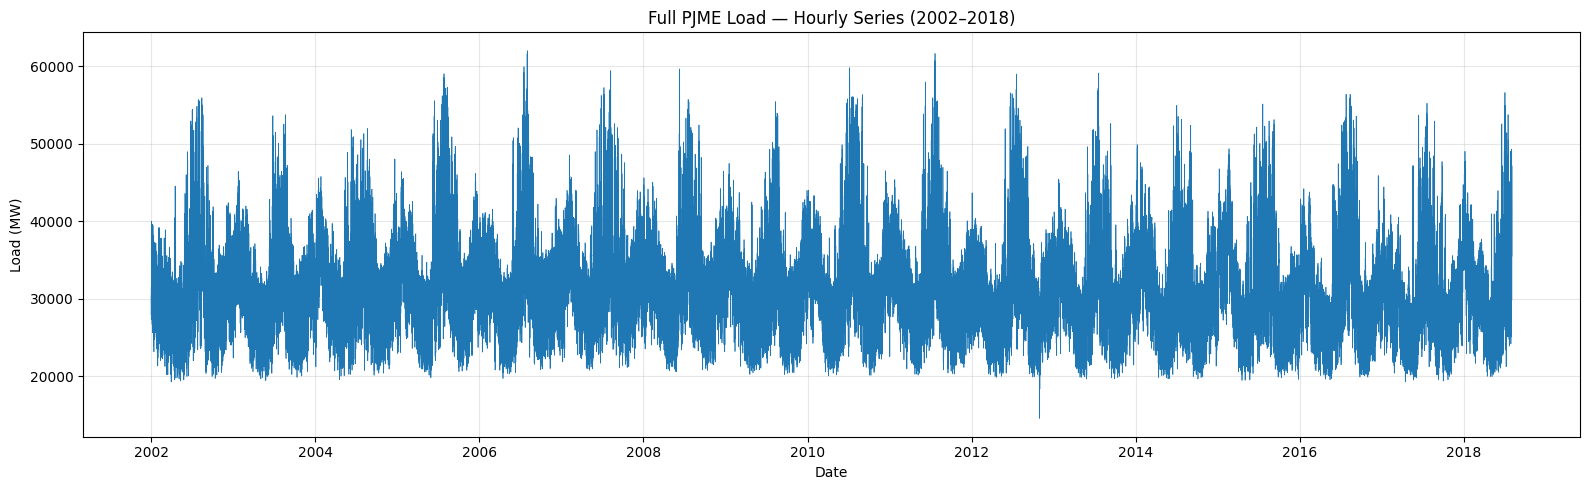

In [7]:
# ---------------------------------------------------------
# 3.1 Global view — full time series
# ---------------------------------------------------------

plt.figure(figsize=(16, 5))
plt.plot(df.index, df["PJME_MW"], linewidth=0.5)
plt.title("Full PJME Load — Hourly Series (2002–2018)")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

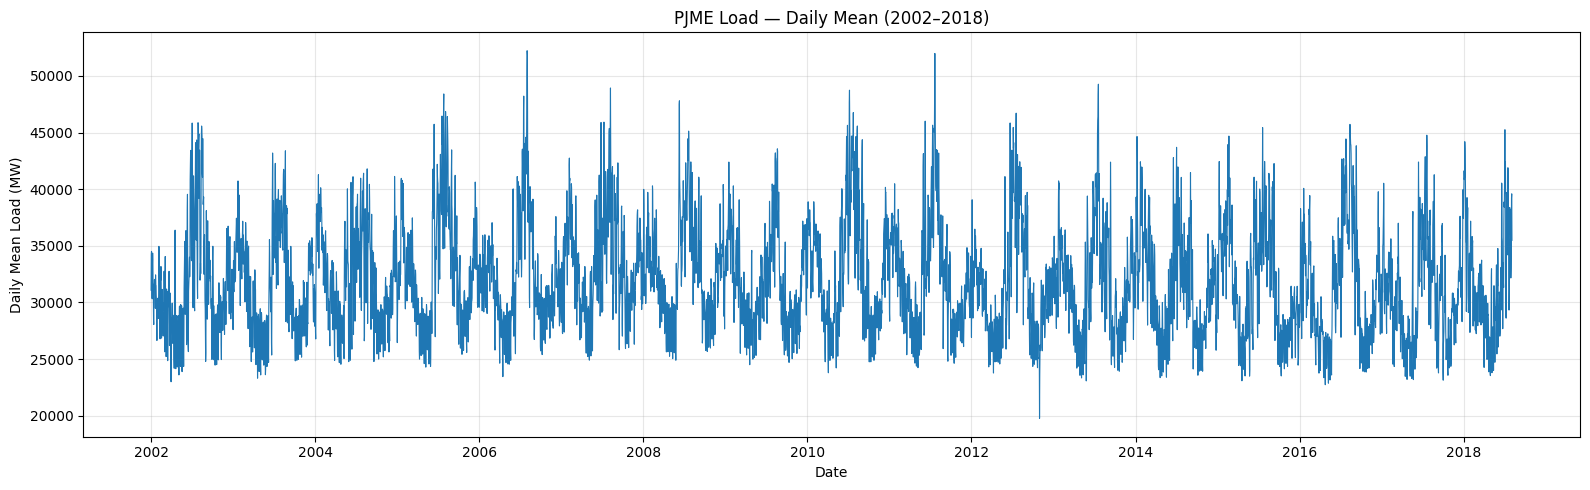

In [8]:
# ---------------------------------------------------------
# 3.1 Global view — daily mean series (smoother)
# ---------------------------------------------------------

daily_mean = df["PJME_MW"].resample("1D").mean()

plt.figure(figsize=(16, 5))
plt.plot(daily_mean.index, daily_mean, linewidth=0.8)
plt.title("PJME Load — Daily Mean (2002–2018)")
plt.xlabel("Date")
plt.ylabel("Daily Mean Load (MW)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

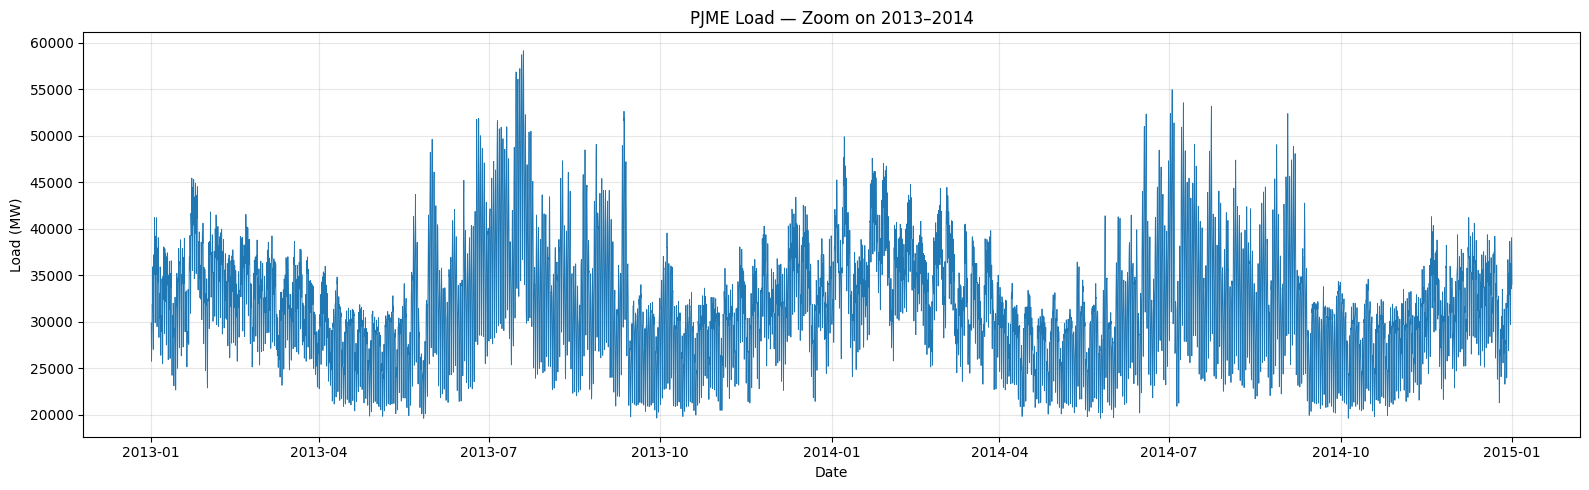

In [9]:
# zoom on 2 representative years

subset = df.loc["2013":"2014"]["PJME_MW"]

plt.figure(figsize=(16, 5))
plt.plot(subset.index, subset, linewidth=0.6)
plt.title("PJME Load — Zoom on 2013–2014")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

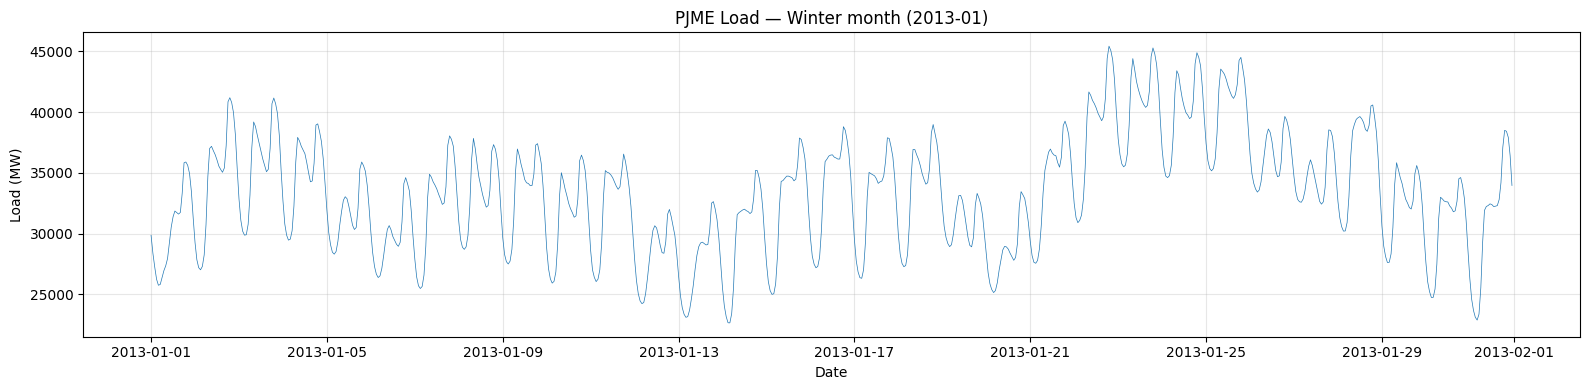

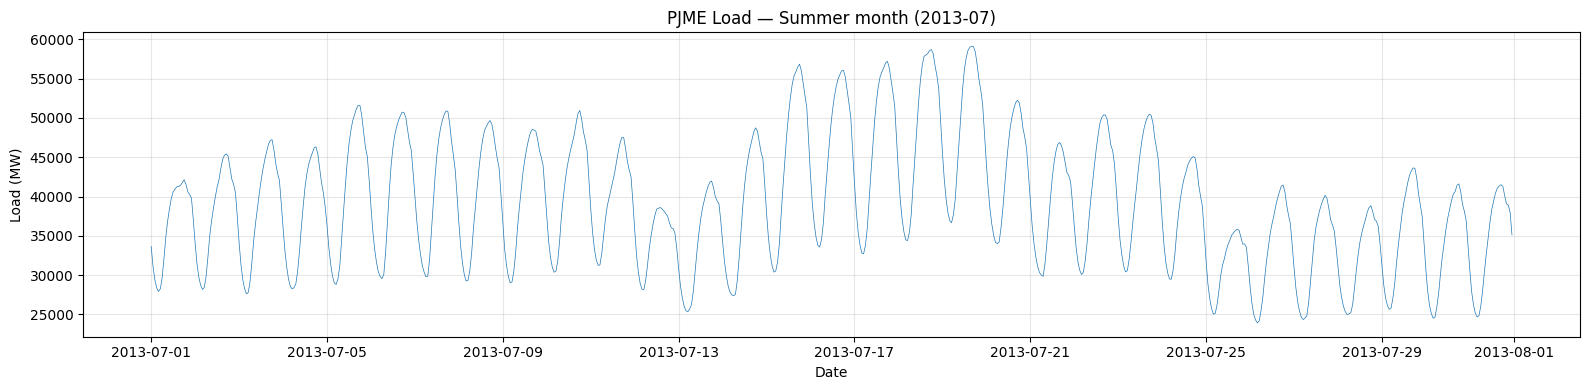

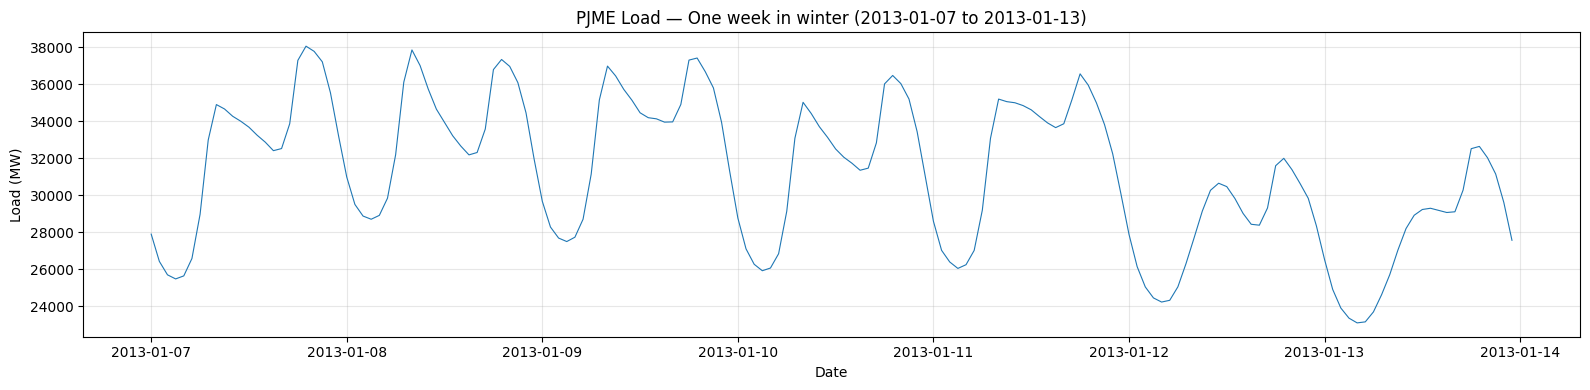

In [10]:
# ---------------------------------------------------------
# 3.2 Weekly / yearly seasonality — zooms
# ---------------------------------------------------------

# Choose a "typical" reference year and months
typical_year = 2013
winter_month = 1   # January
summer_month = 7   # July

# Build slices
winter_slice = df.loc[f"{typical_year}-{winter_month:02d}"]
summer_slice = df.loc[f"{typical_year}-{summer_month:02d}"]

# One representative full week (Monday → Sunday) in winter
week_start = f"{typical_year}-01-07"  # adjust if needed
week_end   = f"{typical_year}-01-13"
week_slice = df.loc[week_start:week_end]

# 1) Winter month
plt.figure(figsize=(16, 4))
plt.plot(winter_slice.index, winter_slice["PJME_MW"], linewidth=0.5)
plt.title(f"PJME Load — Winter month ({typical_year}-{winter_month:02d})")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Summer month
plt.figure(figsize=(16, 4))
plt.plot(summer_slice.index, summer_slice["PJME_MW"], linewidth=0.5)
plt.title(f"PJME Load — Summer month ({typical_year}-{summer_month:02d})")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3) One full winter week (Monday → Sunday)
plt.figure(figsize=(16, 4))
plt.plot(week_slice.index, week_slice["PJME_MW"], linewidth=0.8)
plt.title(f"PJME Load — One week in winter ({week_start} to {week_end})")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Seasonality Observed

The winter month shows a very pronounced **double-peak daily cycle**, with clear morning and evening demand surges.  
A strong **weekly pattern** is visible: weekdays exhibit higher and more structured load profiles, while weekends drop to significantly lower levels.

The summer month, in contrast, displays a much smoother profile with **a single broad daily peak** and **no obvious weekday/weekend separation**.  
Overall, the load exhibits a marked **day–night cycle**, strong **winter–summer contrast**, and a **pronounced working-day effect** that largely disappears in summer.

## 4. Data Quality: Missing Values, Extremes, and Anomalies

Before moving into feature engineering or modelling, it is essential to assess the **intrinsic quality of the signal**.  
This section focuses on identifying potential issues such as:

- **Missing values** (gaps after resampling, propagation of NA during shifts/rollings),
- **Extreme or implausible values** that could distort scaling or loss functions,
- **Local anomalies** (spikes, drops, or flat segments) that may correspond to holidays, outages, or measurement noise.

The goal is not yet to correct everything, but to build a clear picture of the **reliability and stability** of the series.  
Understanding whether anomalies reflect true operational behaviour or artefacts is key before deciding how to treat them in modelling.

In [11]:
# ---------------------------------------------------------
# 4.1 Missing Values — structure and diagnostics
# ---------------------------------------------------------

import numpy as np

# 1) Basic count
n_total = len(df)
n_na = df["PJME_MW"].isna().sum()
pct_na = 100 * n_na / n_total

print("=== Missing Values Summary ===")
print(f"Total rows: {n_total:,}")
print(f"Missing values: {n_na:,} ({pct_na:.4f} %)")
print()

# 2) Identify isolated vs. consecutive missing blocks

na_mask = df["PJME_MW"].isna().values

# Find block boundaries
blocks = []
i = 0
while i < len(na_mask):
    if na_mask[i]:
        start = i
        while i < len(na_mask) and na_mask[i]:
            i += 1
        end = i - 1
        blocks.append((start, end))
    i += 1

# Convert index positions to timestamps
blocks_ts = [
    (df.index[start], df.index[end], end - start + 1)
    for start, end in blocks
]

print("=== Missing Value Blocks ===")
if len(blocks_ts) == 0:
    print("No NA blocks (series is fully complete).")
else:
    print(f"Number of NA blocks: {len(blocks_ts)}")
    print("Preview (start, end, block_size):")
    for b in blocks_ts[:10]:
        print(f"  {b[0]}  →  {b[1]}   | {b[2]} hour(s)")

=== Missing Values Summary ===
Total rows: 145,392
Missing values: 0 (0.0000 %)

=== Missing Value Blocks ===
No NA blocks (series is fully complete).


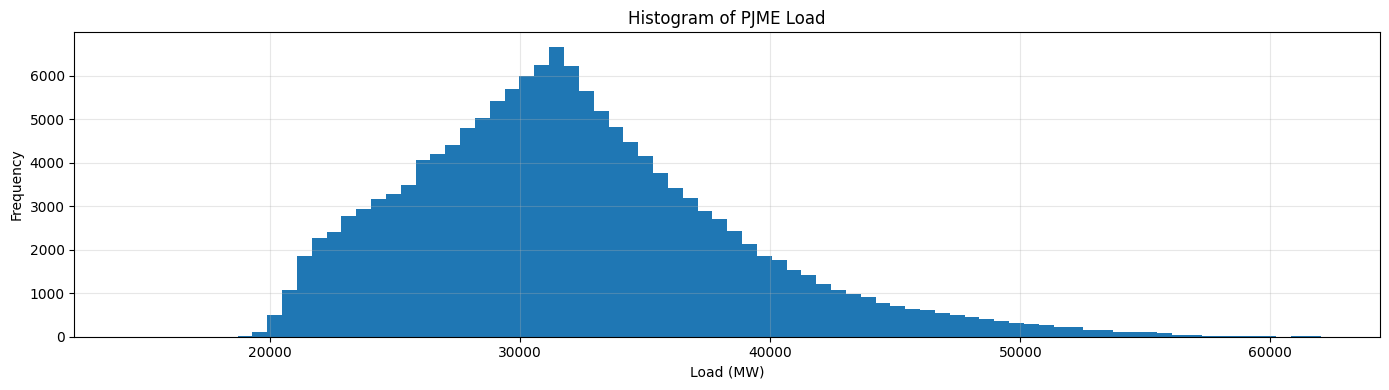

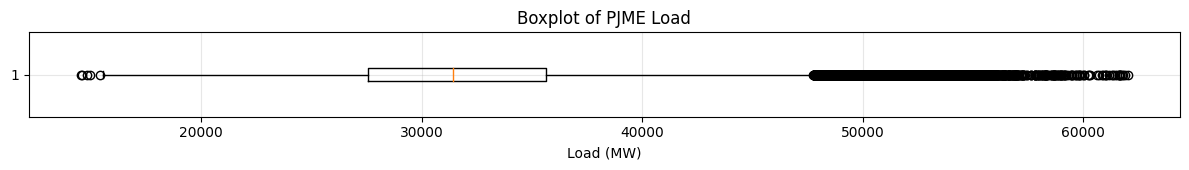

=== Top-k maximum values ===
2006-08-02 17:00:00 → 62009.00 MW
2006-08-02 16:00:00 → 61909.00 MW
2006-08-03 17:00:00 → 61796.00 MW
2006-08-03 16:00:00 → 61770.00 MW
2011-07-22 15:00:00 → 61646.00 MW
2006-08-01 17:00:00 → 61643.00 MW
2006-08-02 15:00:00 → 61641.00 MW
2006-08-02 18:00:00 → 61610.00 MW
2011-07-22 16:00:00 → 61608.00 MW
2011-07-22 14:00:00 → 61532.00 MW

=== Top-k minimum values ===
2012-10-30 04:00:00 → 14544.00 MW
2012-10-30 03:00:00 → 14586.00 MW
2012-10-30 05:00:00 → 14821.00 MW
2012-10-30 02:00:00 → 14955.00 MW
2012-10-30 01:00:00 → 15390.00 MW
2012-10-30 06:00:00 → 15526.00 MW
2012-10-30 00:00:00 → 15919.00 MW
2012-10-30 07:00:00 → 16688.00 MW
2012-10-29 23:00:00 → 17422.00 MW
2012-10-30 08:00:00 → 17734.00 MW

=== Physical Sanity Checks ===
Negative values: 0
Minimum load: 14544.00 MW
Maximum load: 62009.00 MW


In [12]:
# ---------------------------------------------------------
# 4.2 Outliers / Spikes
# ---------------------------------------------------------

series = df["PJME_MW"]

# 1) Basic distribution: histogram + boxplot

plt.figure(figsize=(14,4))
plt.hist(series.dropna(), bins=80)
plt.title("Histogram of PJME Load")
plt.xlabel("Load (MW)")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,1.8))
plt.boxplot(series.dropna(), vert=False)
plt.title("Boxplot of PJME Load")
plt.xlabel("Load (MW)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Identify top-k highest / lowest values

k = 10
top_max = series.nlargest(k)
top_min = series.nsmallest(k)

print("=== Top-k maximum values ===")
for ts, val in top_max.items():
    print(f"{ts} → {val:.2f} MW")

print("\n=== Top-k minimum values ===")
for ts, val in top_min.items():
    print(f"{ts} → {val:.2f} MW")

# 3) Physical sanity checks

n_negative = (series < 0).sum()
max_val = series.max()
min_val = series.min()

print("\n=== Physical Sanity Checks ===")
print(f"Negative values: {n_negative}")
print(f"Minimum load: {min_val:.2f} MW")
print(f"Maximum load: {max_val:.2f} MW")

#### Outlier / spike diagnostic

The distribution of hourly PJME load is strongly right-skewed.  
The bulk of the observations lies between **22,000 MW and 40,000 MW**,  
with a clear mode around **30,000–32,000 MW**.  
The lower tail is sparse but physically reasonable, with a minimum of **14,544 MW**  
and no negative or structurally impossible values.

The upper tail is long and heavily populated:  
a substantial number of observations exceed **45,000 MW**,  
and the distribution extends smoothly up to **~55,000 MW**,  
indicating that high-demand winter periods are frequent rather than isolated.

A smaller set of extreme spikes reaches **61,000–62,000 MW**.  
These values align with known PJM winter peak events during severe cold waves,  
and their smooth integration into the histogram’s right tail strongly suggests  
that they represent **genuine operational peak loads**, not anomalies or measurement noise.

Accordingly, these high-load extremes are **retained as real peaks**  
and will be treated as authentic demand surges in the forecasting benchmark.


## 5. Preparing the Experimental Protocol

Now that the time series has been audited (structure, regularity, seasonality, anomalies),  
we can **lock in the experimental design** before creating any actual train/validation/test splits.

The goal of this section is to specify, in writing:

- **Which periods** will be used for training, validation and final testing,
- **Which horizon** we evaluate ($H = 24$ hours),
- **Which evaluation scheme** we use (rolling-origin / expanding window),
- **Which metrics** will be reported (e.g. MAE, RMSE, MAPE),
- **How we ensure comparability** between models (same splits, same horizon, same target).

At this stage, we do **not** implement the splits yet:  
we only define the rules (dates, windows, frequency of re-fitting, metrics) so that  
all models — SARIMA, Prophet, RandomForest, LSTM — are later evaluated  
under a **single, consistent experimental protocol**.

#### 5.1. Time span used for the benchmark

The PJME series is globally clean over the full period (2002–2018):  
no structural breaks, no large data gaps, and only daylight-saving related artefacts.

For this benchmark, we therefore **keep the entire available history**:

> We retain the period from **2002-01-01** to **2018-08-03** for the forecasting benchmark.

#### 5.2. Train / validation / test splits

We use **strictly temporal splits**, with no shuffling and no overlap between years.

At the scale of the full period (2002-01-01 → 2018-08-03), we fix the following design:

- **Train** (≈ 70 % of the history)  
  From **2002-01-01** to **2014-12-31**.  
  This block is used to fit all models and, where relevant, to tune structural hyperparameters.

- **Validation** (≈ 15 %)  
  From **2015-01-01** to **2016-12-31**.  
  This block is used for model selection and hyperparameter tuning  
  under a shared temporal evaluation scheme.

- **Test** (≈ 15 %)  
  From **2017-01-01** to **2018-08-03**.  
  This block is held out and used **once** for final performance reporting and comparison.

Principle:

> The splits are strictly time-ordered, with no mixing of indices.  
> No observation from a given timestamp appears in more than one of the train, validation or test sets.

#### 5.3. Forecasting horizon and prediction granularity

We fix the forecasting horizon to:

- **Horizon**: $H = 24$ hours  
  → the task is to predict the **next 24 hours of load** from the information available up to time $t$.

- **Prediction frequency**:  
  During the test period, models are evaluated by asking them, **at every hour $t$**,  
  to produce a **24-dimensional prediction vector** for the next day:

  > At each timestamp $t$ in the test set, the model outputs a forecast  
  > for hours $t+1$ to $t+24$.

Formally, we denote by $y_t$ the electric load at time $t$ (in MW).  
Given the past history $\{y_t, y_{t-1}, y_{t-2}, \dots\}$, a forecasting model $f$ produces

$$f(\dots, y_{t-2}, y_{t-1}, y_t) = (\hat{y}_{t+1}, \hat{y}_{t+2}, \dots, \hat{y}_{t+H})$$

with $H = 24$.  
All models in the benchmark (SARIMA, Prophet, RandomForest, LSTM) are evaluated  
on this same **multi-step direct forecasting task**.



## 6. Defining metrics and baselines

### 6.1. Metrics

We fix the evaluation metrics **before** running any experiment, to avoid adaptive bias.

- **MAE (Mean Absolute Error)**  
  Interpretable directly in megawatts, useful for assessing average magnitude of errors.

- **RMSE (Root Mean Squared Error)**  
  Gives more weight to large deviations, appropriate when forecasting peaks is important.

- **sMAPE (Symmetric Mean Absolute Percentage Error)**  
  Reported as a complementary scale-free metric.  
  We note that classical MAPE can become unstable when $y_t$ is close to zero,  
  whereas sMAPE remains more robust but less intuitive.

Decision:

> We will use **MAE** and **RMSE** as the primary evaluation metrics,  
> and report **sMAPE** as a complementary metric.  
> All metrics will be computed at fixed horizon $H = 24$ on the test period.

### 6.2. Baselines

Before evaluating SARIMA, Prophet, RandomForest and LSTM,  
we define two simple forecasting baselines that set a minimal reference level.

- **Baseline 1 — Naive persistence ("tomorrow = now")**  
  For every horizon $h \in \{1, \dots, H\}$:

  $\hat{y}_{t+h} = y_t$

- **Baseline 2 — Same hour last week**  
  Since the series is hourly (168 hours per week):

  $\hat{y}_t = y_{t-168}$

These baselines are not implemented yet; they are simply **locked in as reference models**  
for all later comparisons under the shared evaluation protocol.


## 7. Creating the temporal splits

Now that the experimental protocol is fully defined (Sections 5 and 6),  
we can move from the *design phase* to the *implementation phase*.  
The first step is to materialise the train / validation / test splits on the actual time series.

We do **not** create supervised windows or features yet, we only instantiate the three raw segments: benchmark window, train, validation and test.

In [13]:
# ---------------------------------------------------------
# 7.1 Define benchmark window
# ---------------------------------------------------------

# Define start / end of the benchmark period
start_date_benchmark = "2002-01-01"
end_date_benchmark   = "2018-08-03"

# Filter the DataFrame on this continuous window
df_benchmark = df.loc[start_date_benchmark:end_date_benchmark].copy()

print("=== Benchmark window ===")
print(f"Start date: {df_benchmark.index.min()}")
print(f"End date:   {df_benchmark.index.max()}")
print(f"Number of points: {len(df_benchmark):,}")

=== Benchmark window ===
Start date: 2002-01-01 01:00:00
End date:   2018-08-03 00:00:00
Number of points: 145,392


In [14]:
# ---------------------------------------------------------
# 7.2 Train / validation / test splits
# ---------------------------------------------------------

# Define split boundaries
train_start = "2002-01-01"
train_end   = "2014-12-31"

val_start   = "2015-01-01"
val_end     = "2016-12-31"

test_start  = "2017-01-01"
test_end    = "2018-08-03"

# Build the three subsets by temporal filtering
df_train = df_benchmark.loc[train_start:train_end].copy()
df_val   = df_benchmark.loc[val_start:val_end].copy()
df_test  = df_benchmark.loc[test_start:test_end].copy()

print("=== Temporal splits summary ===")
print(f"Train:      {df_train.index.min()}  →  {df_train.index.max()}  | {len(df_train):,} rows")
print(f"Validation: {df_val.index.min()}  →  {df_val.index.max()}  | {len(df_val):,} rows")
print(f"Test:       {df_test.index.min()}  →  {df_test.index.max()}  | {len(df_test):,} rows")

=== Temporal splits summary ===
Train:      2002-01-01 01:00:00  →  2014-12-31 23:00:00  | 113,951 rows
Validation: 2015-01-01 00:00:00  →  2016-12-31 23:00:00  | 17,544 rows
Test:       2017-01-01 00:00:00  →  2018-08-03 00:00:00  | 13,897 rows


## 8. Formalising the 24h multi-step forecasting setup

### 8.1. Problem definition

We work with a **univariate** time series:

- $y_t = \text{PJME\_MW}$, the hourly electric load at time $t$ (in MW),
- with a fixed forecasting horizon $H = 24$ hours.

At each evaluation time $t$ in the test period, the model is given the history up to $t$  
and must output a 24-dimensional forecast:

$$(\hat{y}_{t+1}, \hat{y}_{t+2}, \dots, \hat{y}_{t+24})$$

This defines a **multi-step direct forecasting** task at a fixed horizon $H = 24$.

### 8.2. Evaluation grid $T_{\text{eval}}$ and test targets

We now define the evaluation grid $T_{\text{eval}}$ on the **test block**:

- $T_{\text{eval}}$ contains all timestamps $t$ in the test period such that  
  the full 24-hour target window $(y_{t+1}, \dots, y_{t+24})$ lies entirely inside the test set.
- For each $t \in T_{\text{eval}}$, we build one row of the target matrix  
  $Y_{\text{true,test}}$ of shape $(N, 24)$:

$$Y_{\text{true,test}}[i, :] = (y_{t_i+1}, \dots, y_{t_i+24})$$

where $(t_i)_{i=1,\dots,N}$ enumerates all evaluation timestamps in $T_{\text{eval}}$.

We only evaluate on timestamps $t$ for which the full 24-hour target window  
is contained in the test period.

In [15]:
# ---------------------------------------------------------
# 8.2 Evaluation grid T_eval and Y_true_test on the test set
# ---------------------------------------------------------

import numpy as np  # if already imported earlier, this is harmless

H = 24  # forecasting horizon (24 hours)

# Extract the test index and values
test_index = df_test.index
y_test = df_test["PJME_MW"].to_numpy()

# We can only evaluate at times t such that t+1, ..., t+H are still in the test set.
# If len(test_index) = M, valid starting positions are 0, ..., M - H - 1.
n_test = len(test_index)
n_eval = n_test - H

# Evaluation timestamps T_eval (as DatetimeIndex)
T_eval = test_index[:n_eval]

# Build Y_true_test with shape (n_eval, H)
Y_true_test = np.stack(
    [y_test[i + 1 : i + H + 1] for i in range(n_eval)],
    axis=0,
)

print("=== Multi-step 24h evaluation grid (test set) ===")
print(f"Horizon H:              {H}")
print(f"Number of test points:  {n_test:,}")
print(f"Number of eval times:   {n_eval:,}")
print(f"Y_true_test shape:      {Y_true_test.shape}")
print()
print(f"First evaluation time:  {T_eval[0]}")
print(f"Last evaluation time:   {T_eval[-1]}")
print("Last target window ends at:", test_index[-1])

=== Multi-step 24h evaluation grid (test set) ===
Horizon H:              24
Number of test points:  13,897
Number of eval times:   13,873
Y_true_test shape:      (13873, 24)

First evaluation time:  2017-01-01 00:00:00
Last evaluation time:   2018-08-02 00:00:00
Last target window ends at: 2018-08-03 00:00:00


## 9. Implementing 24h baselines (no analysis yet)

In this section, we implement two simple 24-hour baselines on the **test set**:

1. **Naive persistence:** the next 24 hours are assumed equal to the last observed value at time $t$.  
2. **Same hour last week:** the forecast at horizon $h$ reuses the value observed exactly 168 hours earlier.

Formally:

- **Baseline 1 (naive persistence):**  
  $\hat{y}_{t+h} = y_t$ for $h = 1, \dots, 24$.

- **Baseline 2 (same hour last week):**  
  $\hat{y}_{t+h} = y_{t+h-168}$ for $h = 1, \dots, 24$.

We use the evaluation grid $T_{\text{eval}}$ and the target matrix $Y_{\text{true,test}}$  
defined in Section 8. We only check **shapes and alignment** at this stage;  
no metrics or plots are computed yet.

In [16]:
# ---------------------------------------------------------
# 9.1 Baseline 1 — Naive persistence (ŷ_{t+h} = y_t)
# ---------------------------------------------------------

import numpy as np  # harmless if already imported earlier

H = Y_true_test.shape[1]          # should be 24
n_eval = Y_true_test.shape[0]     # number of evaluation timestamps

# We reuse the test target series as a flat array
y_test_array = df_test["PJME_MW"].to_numpy()

# For the i-th evaluation time, T_eval[i] corresponds to test_index[i],
# so the naive baseline uses y_test_array[i] repeated H times.
Y_pred_naive_test = np.tile(
    y_test_array[:n_eval].reshape(-1, 1),  # column vector (n_eval, 1)
    (1, H),                                # repeat across H horizons
)

print("=== Baseline 1: Naive persistence ===")
print(f"Y_true_test shape:        {Y_true_test.shape}")
print(f"Y_pred_naive_test shape:  {Y_pred_naive_test.shape}")
print()
print("First row (true vs naive):")
print("y_true[0]: ", Y_true_test[0, :5], "...")
print("y_pred[0]: ", Y_pred_naive_test[0, :5], "...")

=== Baseline 1: Naive persistence ===
Y_true_test shape:        (13873, 24)
Y_pred_naive_test shape:  (13873, 24)

First row (true vs naive):
y_true[0]:  [26879. 25848. 25039. 24637. 24615.] ...
y_pred[0]:  [28171. 28171. 28171. 28171. 28171.] ...


In [17]:
# ---------------------------------------------------------
# 9.2 Baseline 2 — Same hour last week (ŷ_{t+h} = y_{t+h-168})
# ---------------------------------------------------------

week_lag = 168  # hours in one week
H = Y_true_test.shape[1]
n_eval = Y_true_test.shape[0]
y_test_array = df_test["PJME_MW"].to_numpy()

# We cannot evaluate this baseline for the very first 168 test timestamps,
# because we would need y_{t-168} before the start of the test block.
# So we restrict the evaluation grid accordingly.
if n_eval <= week_lag:
    raise ValueError("Not enough test points to support a 168-hour lag baseline.")

n_eval_lastweek = n_eval - week_lag

# Restricted evaluation grid and corresponding true targets
T_eval_lastweek = T_eval[week_lag:]
Y_true_test_lastweek = Y_true_test[week_lag:, :]   # shape (n_eval_lastweek, H)

# Allocate prediction matrix aligned with Y_true_test_lastweek
Y_pred_lastweek_test = np.empty_like(Y_true_test_lastweek)

# For each evaluation index i0 (absolute index in test), and horizon h:
# ŷ_{t+h} = y_{t+h-168}  → index in y_test_array is (i0 + h - week_lag)
for r in range(n_eval_lastweek):
    i0 = week_lag + r  # absolute index in the test series for this evaluation time
    for h in range(1, H + 1):
        p_idx = i0 + h - week_lag
        Y_pred_lastweek_test[r, h - 1] = y_test_array[p_idx]

print("=== Baseline 2: Same hour last week ===")
print(f"T_eval_lastweek length:        {len(T_eval_lastweek)}")
print(f"Y_true_test_lastweek shape:   {Y_true_test_lastweek.shape}")
print(f"Y_pred_lastweek_test shape:   {Y_pred_lastweek_test.shape}")
print()
print("First row (true vs last-week):")
print("y_true_lastweek[0]: ", Y_true_test_lastweek[0, :5], "...")
print("y_pred_lastweek[0]: ", Y_pred_lastweek_test[0, :5], "...")

=== Baseline 2: Same hour last week ===
T_eval_lastweek length:        13705
Y_true_test_lastweek shape:   (13705, 24)
Y_pred_lastweek_test shape:   (13705, 24)

First row (true vs last-week):
y_true_lastweek[0]:  [34856. 34165. 33870. 33886. 34312.] ...
y_pred_lastweek[0]:  [26879. 25848. 25039. 24637. 24615.] ...


## 10. Standardised evaluation function

### 10.1. Metric definitions (MAE / RMSE / sMAPE)

We evaluate forecasts using three metrics, computed on **24-hour forecast vectors**:

- Let $Y_{\text{true}} \in \mathbb{R}^{N \times H}$ and $Y_{\text{pred}} \in \mathbb{R}^{N \times H}$  
  be the matrices of true and predicted values, with $H = 24$.

For global metrics, we flatten them into vectors of length $N \cdot H$:

- $y = \text{vec}(Y_{\text{true}})$  
- $\hat{y} = \text{vec}(Y_{\text{pred}})$

We then define:

- **MAE (Mean Absolute Error)**  
  $$
  \text{MAE} = \frac{1}{N H} \sum_{i=1}^{N H} \lvert y_i - \hat{y}_i \rvert
  $$

- **RMSE (Root Mean Squared Error)**  
  $$
  \text{RMSE} = \sqrt{ \frac{1}{N H} \sum_{i=1}^{N H} (y_i - \hat{y}_i)^2 }
  $$

- **sMAPE (Symmetric Mean Absolute Percentage Error)**  
  $$
  \text{sMAPE} = \frac{100}{N H} \sum_{i=1}^{N H}
  \frac{2 \lvert y_i - \hat{y}_i \rvert}{\lvert y_i \rvert + \lvert \hat{y}_i \rvert + \varepsilon}
  $$
  where $\varepsilon$ is a small constant to avoid division by zero  
  when both $y_i$ and $\hat{y}_i$ are close to zero.

All three metrics are computed on the **flattened 24-hour grids**,  
so they reflect the average error over **all horizons** and **all evaluation timestamps**.


### 10.2. Implementing the evaluation helper

We now implement a reusable helper:

`evaluate_forecast(Y_true, Y_pred) -> dict(mae=..., rmse=..., smape=...)`.

It expects `Y_true` and `Y_pred` with identical shape `(N, H)`,  
flattens them internally, and returns the three metrics as floats.

In [18]:
# ---------------------------------------------------------
# 10.2 Standardised evaluation function
# ---------------------------------------------------------

def evaluate_forecast(Y_true: np.ndarray, Y_pred: np.ndarray, eps: float = 1e-8) -> dict:
    """
    Compute MAE, RMSE and sMAPE between true and predicted multi-step forecasts.

    Parameters
    ----------
    Y_true : np.ndarray
        Array of true values with shape (N, H).
    Y_pred : np.ndarray
        Array of predicted values with shape (N, H).
    eps : float, optional
        Small constant to avoid division by zero in sMAPE.

    Returns
    -------
    metrics : dict
        Dictionary with keys "mae", "rmse", "smape".
    """
    # Ensure arrays and shapes are compatible
    Y_true = np.asarray(Y_true, dtype=float)
    Y_pred = np.asarray(Y_pred, dtype=float)

    if Y_true.shape != Y_pred.shape:
        raise ValueError(f"Shape mismatch: Y_true {Y_true.shape} vs Y_pred {Y_pred.shape}")

    # Flatten to (N * H,)
    y = Y_true.ravel()
    y_hat = Y_pred.ravel()

    # MAE
    abs_errors = np.abs(y - y_hat)
    mae = abs_errors.mean()

    # RMSE
    sq_errors = (y - y_hat) ** 2
    rmse = np.sqrt(sq_errors.mean())

    # sMAPE
    denom = np.abs(y) + np.abs(y_hat) + eps
    smape = (200.0 * (abs_errors / denom)).mean()

    return {"mae": mae, "rmse": rmse, "smape": smape}


# ---------------------------------------------------------
# Quick sanity check on the baselines (no interpretation yet)
# ---------------------------------------------------------

print("=== Sanity check: evaluation function on baselines ===")

metrics_naive = evaluate_forecast(Y_true_test, Y_pred_naive_test)
print("Naive baseline (full test grid):", metrics_naive)

metrics_lastweek = evaluate_forecast(Y_true_test_lastweek, Y_pred_lastweek_test)
print("Last-week baseline (restricted grid):", metrics_lastweek)

=== Sanity check: evaluation function on baselines ===
Naive baseline (full test grid): {'mae': 4472.634968403854, 'rmse': 5967.148798580806, 'smape': 14.393949388682367}
Last-week baseline (restricted grid): {'mae': 3521.4679405326524, 'rmse': 4804.837631249865, 'smape': 10.92790096841586}


## 11. Implementing SARIMA

We now add a first **parametric time-series model** to the benchmark: SARIMA,  
implemented via `statsmodels.tsa.statespace.SARIMAX`.

The goal of this section is not to perfectly tune SARIMA, but to:

1. Run a **light configuration search** on the **train / validation** blocks,  
2. Check that the **24h multi-step forecasting pipeline** works end-to-end,  
3. Produce a **final SARIMA model** trained on `train + validation` and evaluated on the **test** grid.

At this stage, we focus on:

- getting `Y_pred_sarima_val` and `Y_pred_sarima_test` with shape `(N, 24)`,  
- aligning them with `Y_true_val` / `Y_true_test`,  
- optionally computing metrics via `evaluate_forecast` (but without analysing them yet).

In [19]:
# ---------------------------------------------------------
# 11. SARIMA benchmark (statsmodels)
# ---------------------------------------------------------
# Protocol
# --------
# - Validation step:
#     * Fit SARIMA only on the TRAIN block (or a recent subset of it).
#     * Evaluate on the VALIDATION block using the same H-step
#       multi-step grid as the baselines.
# - Test step:
#     * Refit SARIMA on TRAIN + VALIDATION (or a recent subset of it).
#     * Evaluate once on the TEST block using Y_true_test / T_eval
#       defined in Section 8.
# - No data from TEST is ever used during training or model selection.
# ---------------------------------------------------------

H = 24          # forecasting horizon (hours)
SARIMA_YEARS = 5  # number of years of history used by SARIMA


# Small helper (if not defined earlier) to build multi-step grids
def build_eval_grid(index, y, H: int):
    """
    Build an H-step-ahead multi-step evaluation grid.

    Parameters
    ----------
    index : pandas.DatetimeIndex
        Datetime index for the target series.
    y : np.ndarray
        Target values aligned with `index`.
    H : int
        Forecast horizon in steps.

    Returns
    -------
    T_eval : pandas.DatetimeIndex
        Evaluation timestamps t such that (t+1 ... t+H) are available.
    Y_true : np.ndarray of shape (n_eval, H)
        Ground truth future values for each evaluation time.
    """
    n = len(index)
    n_eval = n - H
    if n_eval <= 0:
        raise ValueError("Not enough points to build an H-step evaluation grid.")

    T_eval = index[:n_eval]
    Y_true = np.stack(
        [y[i + 1 : i + H + 1] for i in range(n_eval)],
        axis=0,
    )
    return T_eval, Y_true

In [20]:
# ---------------------------------------------------------
# 11.1 SARIMA (train subset → validation)
# ---------------------------------------------------------

print("\n=== SARIMA training (for validation) ===")

# Free any leftover SARIMA objects
gc.collect()

# Use the last SARIMA_YEARS of the TRAIN block
train_end = df_train.index.max()
train_sarima_start = (train_end - pd.DateOffset(years=SARIMA_YEARS)).strftime("%Y-%m-%d")

df_train_sarima = df_train.loc[train_sarima_start:].copy()
y_train_sarima = df_train_sarima["PJME_MW"].astype(float)

print("SARIMA training window (TRAIN subset):")
print(f"Start : {df_train_sarima.index.min()}  |  End : {df_train_sarima.index.max()}")
print(f"Length: {len(df_train_sarima):,} hours")

# ------------------
# Validation grid
# ------------------
val_index = df_val.index
y_val = df_val["PJME_MW"].astype(float).to_numpy()

T_eval_val, Y_true_val = build_eval_grid(val_index, y_val, H)
n_eval_val = len(T_eval_val)

print("\nValidation grid:")
print(f"- H           = {H} steps")
print(f"- n_val       = {len(val_index):,}")
print(f"- n_eval_val  = {n_eval_val:,}")
print("Y_true_val shape:", Y_true_val.shape, "\n")

# ------------------
# SARIMA configuration
# ------------------
sarima_order = (1, 0, 1)
sarima_seasonal_order = (0, 1, 1, 24)
print("Using SARIMA config:", sarima_order, sarima_seasonal_order)

# Fit SARIMA on raw training data (statsmodels handles differencing internally)
t0 = time.perf_counter()
model_val = sm.tsa.SARIMAX(
    y_train_sarima,
    order=sarima_order,
    seasonal_order=sarima_seasonal_order,
    simple_differencing=False,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
res_val = model_val.fit(method="lbfgs", maxiter=80, disp=False)
t1 = time.perf_counter()
print(f"SARIMA model (validation) fitted in {t1 - t0:.2f} seconds")

# Forecast the entire validation block + H extra hours
t0 = time.perf_counter()
fc_val = res_val.get_forecast(steps=len(df_val) + H)
y_hat_val_full = fc_val.predicted_mean.to_numpy()  # shape: (n_val + H,)
t1 = time.perf_counter()
print(f"SARIMA forecast (validation) completed in {t1 - t0:.2f} seconds")

# Build Y_pred_sarima_val aligned with Y_true_val
Y_pred_sarima_val = np.stack(
    [y_hat_val_full[i + 1 : i + H + 1] for i in range(n_eval_val)],
    axis=0,
)

print("Y_pred_sarima_val shape:", Y_pred_sarima_val.shape)

# ------------------
# Metrics
# ------------------
sarima_val_metrics = evaluate_forecast(Y_true_val, Y_pred_sarima_val)

print("\n=== SARIMA (train subset → val) metrics ===")
for k, v in sarima_val_metrics.items():
    print(f"{k.upper():6s}: {v:,.3f}")

# Free RAM (keep Y_true_val / Y_pred_sarima_val for later comparison)
del df_train_sarima, y_train_sarima, fc_val, y_hat_val_full
gc.collect()


=== SARIMA training (for validation) ===
SARIMA training window (TRAIN subset):
Start : 2009-12-31 00:00:00  |  End : 2014-12-31 23:00:00
Length: 43,848 hours

Validation grid:
- H           = 24 steps
- n_val       = 17,544
- n_eval_val  = 17,520
Y_true_val shape: (17520, 24) 

Using SARIMA config: (1, 0, 1) (0, 1, 1, 24)
SARIMA model (validation) fitted in 115.87 seconds
SARIMA forecast (validation) completed in 1.86 seconds
Y_pred_sarima_val shape: (17520, 24)

=== SARIMA (train subset → val) metrics ===
MAE   : 5,022.816
RMSE  : 6,020.632
SMAPE : 15.727


17

In [21]:
# ---------------------------------------------------------
# 11.2 SARIMA (train+val subset → test)
# ---------------------------------------------------------

print("\n=== SARIMA training (for test) ===")

# Free RAM from the validation fit (we keep only Y_true / Y_pred)
try:
    del model_val, res_val, fc_val, y_hat_val_full
except NameError:
    pass
gc.collect()

best_order = sarima_order
best_seasonal_order = sarima_seasonal_order
print("Using SARIMA config for TEST:", best_order, best_seasonal_order)

# ------------------
# TRAIN+VAL window for final fit
# ------------------
trainval = pd.concat([df_train, df_val])
trainval_end = trainval.index.max()
trainval_sarima_start = (trainval_end - pd.DateOffset(years=SARIMA_YEARS)).strftime("%Y-%m-%d")

df_trainval_sarima = trainval.loc[trainval_sarima_start:].copy()
y_trainval_sarima = df_trainval_sarima["PJME_MW"].astype(float)

print("SARIMA training window (TRAIN+VAL subset):")
print(f"Start : {df_trainval_sarima.index.min()}  |  End : {df_trainval_sarima.index.max()}")
print(f"Length: {len(df_trainval_sarima):,} hours")

# ------------------
# Test grid (already defined in Section 8)
# ------------------
test_index = df_test.index
y_test = df_test["PJME_MW"].astype(float).to_numpy()
n_test = len(test_index)

H = Y_true_test.shape[1]
n_eval_test = Y_true_test.shape[0]

print("\nTest grid:")
print(f"- H           = {H} steps")
print(f"- n_test      = {n_test:,}")
print(f"- n_eval_test = {n_eval_test:,}")
print("Y_true_test shape:", Y_true_test.shape, "\n")

# ------------------
# Final SARIMA fit on TRAIN+VAL subset
# ------------------
t0 = time.perf_counter()
model_final = sm.tsa.SARIMAX(
    y_trainval_sarima,
    order=best_order,
    seasonal_order=best_seasonal_order,
    simple_differencing=False,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
res_final = model_final.fit(method="lbfgs", maxiter=80, disp=False)
t1 = time.perf_counter()
print(f"SARIMA model (test) fitted in {t1 - t0:.2f} seconds")

# Forecast the entire TEST block + H extra hours
t0 = time.perf_counter()
fc_test = res_final.get_forecast(steps=n_test + H)
y_hat_test_full = fc_test.predicted_mean.to_numpy()  # shape: (n_test + H,)
t1 = time.perf_counter()
print(f"SARIMA forecast (test) completed in {t1 - t0:.2f} seconds")

# Build Y_pred_sarima_test aligned with Y_true_test
Y_pred_sarima_test = np.stack(
    [y_hat_test_full[i + 1 : i + H + 1] for i in range(n_eval_test)],
    axis=0,
)

print("Y_pred_sarima_test shape:", Y_pred_sarima_test.shape)

# ------------------
# Metrics
# ------------------
sarima_test_metrics = evaluate_forecast(Y_true_test, Y_pred_sarima_test)

print("\n=== SARIMA (train+val subset → test) metrics ===")
for k, v in sarima_test_metrics.items():
    print(f"{k.upper():6s}: {v:,.3f}")

# Free RAM (keep Y_true_test / Y_pred_sarima_test for later comparison)
del df_trainval_sarima, y_trainval_sarima, fc_test, y_hat_test_full, y_test
gc.collect()


=== SARIMA training (for test) ===
Using SARIMA config for TEST: (1, 0, 1) (0, 1, 1, 24)
SARIMA training window (TRAIN+VAL subset):
Start : 2011-12-31 00:00:00  |  End : 2016-12-31 23:00:00
Length: 43,872 hours

Test grid:
- H           = 24 steps
- n_test      = 13,897
- n_eval_test = 13,873
Y_true_test shape: (13873, 24) 

SARIMA model (test) fitted in 138.99 seconds
SARIMA forecast (test) completed in 1.36 seconds
Y_pred_sarima_test shape: (13873, 24)

=== SARIMA (train+val subset → test) metrics ===
MAE   : 3,971.171
RMSE  : 5,327.238
SMAPE : 12.558


17

### SARIMA — Benchmark Interpretation

The SARIMA model improves once constrained to a recent, more homogeneous training window, but its performance remains below the last-week seasonal baseline. This is expected on hourly electricity load: the series is strongly multi-seasonal (daily and weekly cycles), whereas SARIMA can only model one seasonal period at a time. As a result, the model captures short-term structure but cannot reproduce the dominant 168-hour weekly pattern, which the last-week baseline exploits directly.  

In practice, this confirms SARIMA as a reasonable statistical benchmark, but not a competitive one for this dataset. Surpassing the seasonal naïve baseline requires models that can handle multi-seasonality explicitly (SARIMAX with Fourier terms, Prophet, TBATS, or ML-based regressors).

## 12. Implementing SARIMAX with Fourier seasonality

SARIMA has a known structural limitation: it can only model **one seasonal cycle** at a time  
(e.g., daily cycle with period 24, or weekly cycle with period 168, but not both).

Electric load data, however, is **multi-seasonal**:

- daily pattern (24h),
- weekly pattern (168h),
- annual macro-structure.

In this section, we extend the previous SARIMA approach to **SARIMAX**, by adding  
**Fourier terms** as exogenous variables.  
This allows us to capture both the daily and weekly cycles within a single model.

The goals of this section are:

1. Build exogenous features using **daily and weekly Fourier harmonics**,  
2. Fit a SARIMAX model on a **recent subset of the train block** and  
   evaluate it on the **validation** grid (same multi-step H=24 structure),  
3. Refit SARIMAX on `train + validation` and evaluate it on the **test** grid,  
   producing `Y_pred_sarimax_val` and `Y_pred_sarimax_test` with shape `(N, 24)`.

We follow the *exact same protocol* as in Section 11:

- strictly respecting the temporal splits,  
- performing 24-hour **multi-step** forecasts in a recursive state-space fashion,  
- producing predictions aligned with `Y_true_val` and `Y_true_test`,  
- and computing metrics via `evaluate_forecast` (without interpretation yet).

This SARIMAX is therefore a **stronger statistical baseline** than plain SARIMA,  
as it integrates richer seasonality without violating the benchmark rules.

In [22]:
# ---------------------------------------------------------
# 12. SARIMAX with light Fourier seasonality (fast version)
# ---------------------------------------------------------
# Goal
# ----
# Start with a *lightweight* SARIMAX:
# - keep a daily seasonal period (s = 24),
# - add low-order Fourier terms for daily + weekly cycles,
# - restrict training to the last SARIMAX_YEARS years,
# - keep maxiter modest for faster convergence.
#
# This is a "v1" SARIMAX meant to be fast. If needed, we can
# later increase:
#   - the training window,
#   - the Fourier orders,
#   - or the seasonal complexity.
# ---------------------------------------------------------

H = Y_true_test.shape[1]      # 24
SARIMAX_YEARS = 3             # lighter window for SARIMAX training

In [23]:
# ---------------------------------------------------------
# 12.1 Build exogenous calendar / Fourier features
# ---------------------------------------------------------

def make_sarimax_exog(index, daily_order: int = 2, weekly_order: int = 2):
    """
    Build exogenous Fourier features for SARIMAX based on the datetime index.

    Parameters
    ----------
    index : pandas.DatetimeIndex
        Datetime index for which to build features.
    daily_order : int
        Number of daily harmonics.
    weekly_order : int
        Number of weekly harmonics.

    Returns
    -------
    exog : pandas.DataFrame
        Exogenous feature matrix with Fourier terms for daily and weekly cycles.
    """
    idx = index if isinstance(index, pd.DatetimeIndex) else pd.DatetimeIndex(index)

    # Hour-of-day in [0, 24)
    hour_of_day = idx.hour + idx.minute / 60.0

    # Hour-of-week in [0, 168)
    dow = idx.dayofweek  # Monday=0, Sunday=6
    hour_of_week = dow * 24 + idx.hour + idx.minute / 60.0

    data = {}

    # Daily Fourier terms (period = 24h)
    for k in range(1, daily_order + 1):
        angle_d = 2.0 * np.pi * k * hour_of_day / 24.0
        data[f"sin_d{k}"] = np.sin(angle_d)
        data[f"cos_d{k}"] = np.cos(angle_d)

    # Weekly Fourier terms (period = 168h)
    for k in range(1, weekly_order + 1):
        angle_w = 2.0 * np.pi * k * hour_of_week / (24.0 * 7.0)
        data[f"sin_w{k}"] = np.sin(angle_w)
        data[f"cos_w{k}"] = np.cos(angle_w)

    return pd.DataFrame(data, index=idx)


print("=== Building SARIMAX exogenous features (light) ===")
exog_train = make_sarimax_exog(df_train.index)
exog_val   = make_sarimax_exog(df_val.index)
exog_test  = make_sarimax_exog(df_test.index)

print("Exog shapes:")
print("train:", exog_train.shape, "| val:", exog_val.shape, "| test:", exog_test.shape)

=== Building SARIMAX exogenous features (light) ===
Exog shapes:
train: (113951, 8) | val: (17544, 8) | test: (13897, 8)


In [24]:
# ---------------------------------------------------------
# 12.2 SARIMAX (train subset → validation)
# ---------------------------------------------------------

print("\n=== SARIMAX training (for validation) ===")

# Free leftover SARIMAX objects (if any)
try:
    del model_sarimax_val, res_sarimax_val, fc_sarimax_val, y_hat_val_full
except NameError:
    pass
gc.collect()

# ------------------
# TRAIN subset (last SARIMAX_YEARS)
# ------------------
train_end = df_train.index.max()
train_sarimax_start = (train_end - pd.DateOffset(years=SARIMAX_YEARS)).strftime("%Y-%m-%d")

df_train_sarimax = df_train.loc[train_sarimax_start:].copy()
exog_train_sarimax = exog_train.loc[train_sarimax_start:].copy()
y_train_sarimax = df_train_sarimax["PJME_MW"].astype(float)

print("SARIMAX training window (TRAIN subset):")
print(f"Start : {df_train_sarimax.index.min()}  |  End : {df_train_sarimax.index.max()}")
print(f"Length: {len(df_train_sarimax):,} hours")
print("Exog train subset shape:", exog_train_sarimax.shape)

# ------------------
# Validation grid
# ------------------
val_index = df_val.index
y_val = df_val["PJME_MW"].astype(float).to_numpy()
n_val = len(val_index)

n_eval_val = n_val - H
if n_eval_val <= 0:
    raise ValueError("Not enough validation points to build an H-step grid.")

T_eval_val_sarimax = val_index[:n_eval_val]
Y_true_val_sarimax = np.stack(
    [y_val[i + 1 : i + 1 + H] for i in range(n_eval_val)],
    axis=0,
)

print("\nValidation grid:")
print(f"- H           = {H}")
print(f"- n_val       = {n_val:,}")
print(f"- n_eval_val  = {n_eval_val:,}")
print("Y_true_val_sarimax shape:", Y_true_val_sarimax.shape, "\n")

# ------------------
# SARIMAX configuration (light)
# ------------------
sarimax_order = (1, 0, 1)
sarimax_seasonal_order = (0, 1, 1, 24)
print("Using SARIMAX config (light):", sarimax_order, sarimax_seasonal_order)

# ------------------
# Fit SARIMAX on TRAIN subset
# ------------------
t0 = time.perf_counter()
model_sarimax_val = sm.tsa.SARIMAX(
    y_train_sarimax,
    exog=exog_train_sarimax.to_numpy(),
    order=sarimax_order,
    seasonal_order=sarimax_seasonal_order,
    simple_differencing=False,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
res_sarimax_val = model_sarimax_val.fit(method="lbfgs", maxiter=40, disp=False)
t1 = time.perf_counter()
print(f"SARIMAX model (validation) fitted in {t1 - t0:.2f} seconds")

# ------------------
# Forecast entire VALIDATION block
# ------------------
t0 = time.perf_counter()
fc_sarimax_val = res_sarimax_val.get_forecast(
    steps=n_val,
    exog=exog_val.to_numpy(),
)
y_hat_val_full = fc_sarimax_val.predicted_mean.to_numpy()  # (n_val,)
t1 = time.perf_counter()
print(f"SARIMAX forecast (validation) completed in {t1 - t0:.2f} seconds")

# Build multi-step predictions aligned with Y_true_val_sarimax
Y_pred_sarimax_val = np.stack(
    [y_hat_val_full[i + 1 : i + 1 + H] for i in range(n_eval_val)],
    axis=0,
)

print("Y_pred_sarimax_val shape:", Y_pred_sarimax_val.shape)

# ------------------
# Metrics
# ------------------
sarimax_val_metrics = evaluate_forecast(Y_true_val_sarimax, Y_pred_sarimax_val)

print("\n=== SARIMAX (train subset → val, light) metrics ===")
for k, v in sarimax_val_metrics.items():
    print(f"{k.upper():6s}: {v:,.3f}")

# ------------------
# Free RAM (keep predictions for next sections)
# ------------------
del df_train_sarimax, exog_train_sarimax, y_train_sarimax
del fc_sarimax_val, y_hat_val_full
gc.collect()


=== SARIMAX training (for validation) ===
SARIMAX training window (TRAIN subset):
Start : 2011-12-31 00:00:00  |  End : 2014-12-31 23:00:00
Length: 26,328 hours
Exog train subset shape: (26328, 8)

Validation grid:
- H           = 24
- n_val       = 17,544
- n_eval_val  = 17,520
Y_true_val_sarimax shape: (17520, 24) 

Using SARIMAX config (light): (1, 0, 1) (0, 1, 1, 24)
SARIMAX model (validation) fitted in 608.28 seconds
SARIMAX forecast (validation) completed in 2.32 seconds
Y_pred_sarimax_val shape: (17520, 24)

=== SARIMAX (train subset → val, light) metrics ===
MAE   : 4,625.702
RMSE  : 5,685.971
SMAPE : 14.464


17

In [25]:
# ---------------------------------------------------------
# 12.3 SARIMAX (train+val subset → test)
# ---------------------------------------------------------

print("\n=== SARIMAX training (for test) ===")

# Free leftover objects from validation
try:
    del model_sarimax_val, res_sarimax_val, fc_sarimax_val, y_hat_val_full
except NameError:
    pass
gc.collect()

# ------------------
# TRAIN + VAL subset (last SARIMAX_YEARS)
# ------------------
trainval = pd.concat([df_train, df_val])
exog_trainval = pd.concat([exog_train, exog_val])

trainval_end = trainval.index.max()
trainval_sarimax_start = (trainval_end - pd.DateOffset(years=SARIMAX_YEARS)).strftime("%Y-%m-%d")

df_trainval_sarimax = trainval.loc[trainval_sarimax_start:].copy()
exog_trainval_sarimax = exog_trainval.loc[trainval_sarimax_start:].copy()
y_trainval_sarimax = df_trainval_sarimax["PJME_MW"].astype(float)

print("SARIMAX training window (TRAIN+VAL subset):")
print(f"Start : {df_trainval_sarimax.index.min()}  |  End : {df_trainval_sarimax.index.max()}")
print(f"Length: {len(df_trainval_sarimax):,} hours")
print("Exog train+val subset shape:", exog_trainval_sarimax.shape)

# ------------------
# Test grid
# ------------------
test_index = df_test.index
y_test = df_test["PJME_MW"].astype(float).to_numpy()
n_test = len(test_index)

n_eval_test = Y_true_test.shape[0]

print("\nTest grid:")
print(f"- H           = {H}")
print(f"- n_test      = {n_test:,}")
print(f"- n_eval_test = {n_eval_test:,}")
print("Y_true_test shape:", Y_true_test.shape, "\n")

# ------------------
# Fit SARIMAX on TRAIN+VAL subset
# ------------------
t0 = time.perf_counter()
model_sarimax_test = sm.tsa.SARIMAX(
    y_trainval_sarimax,
    exog=exog_trainval_sarimax.to_numpy(),
    order=sarimax_order,
    seasonal_order=sarimax_seasonal_order,
    simple_differencing=False,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
res_sarimax_test = model_sarimax_test.fit(method="lbfgs", maxiter=40, disp=False)
t1 = time.perf_counter()
print(f"SARIMAX model (test) fitted in {t1 - t0:.2f} seconds")

# ------------------
# Forecast over the entire TEST block
# ------------------
t0 = time.perf_counter()
fc_sarimax_test = res_sarimax_test.get_forecast(
    steps=n_test,
    exog=exog_test.to_numpy(),
)
y_hat_test_full = fc_sarimax_test.predicted_mean.to_numpy()  # shape: (n_test,)
t1 = time.perf_counter()
print(f"SARIMAX forecast (test) completed in {t1 - t0:.2f} seconds")

# ------------------
# Build multi-step predictions (aligned with Y_true_test)
# ------------------
Y_pred_sarimax_test = np.stack(
    [y_hat_test_full[i + 1 : i + 1 + H] for i in range(n_eval_test)],
    axis=0,
)

print("Y_pred_sarimax_test shape:", Y_pred_sarimax_test.shape)

# ------------------
# Metrics
# ------------------
sarimax_test_metrics = evaluate_forecast(Y_true_test, Y_pred_sarimax_test)

print("\n=== SARIMAX (train+val → test, light) metrics ===")
for k, v in sarimax_test_metrics.items():
    print(f"{k.upper():6s}: {v:,.3f}")

# ------------------
# Free RAM (keep test predictions intact)
# ------------------
del df_trainval_sarimax, exog_trainval_sarimax, y_trainval_sarimax
del fc_sarimax_test, y_hat_test_full, y_test
gc.collect()


=== SARIMAX training (for test) ===
SARIMAX training window (TRAIN+VAL subset):
Start : 2013-12-31 00:00:00  |  End : 2016-12-31 23:00:00
Length: 26,328 hours
Exog train+val subset shape: (26328, 8)

Test grid:
- H           = 24
- n_test      = 13,897
- n_eval_test = 13,873
Y_true_test shape: (13873, 24) 

SARIMAX model (test) fitted in 590.72 seconds
SARIMAX forecast (test) completed in 1.51 seconds
Y_pred_sarimax_test shape: (13873, 24)

=== SARIMAX (train+val → test, light) metrics ===
MAE   : 4,152.513
RMSE  : 5,159.830
SMAPE : 13.177


17

## 13. Implementing Prophet (Meta / Facebook Prophet)

Prophet is a decomposable forecasting model widely used in industry.  
It models the series as:

$$ y(t) = \text{trend}(t) + \text{seasonality}(t) + \text{holiday}(t) + \varepsilon_t. $$

It supports:
- automatic changepoints,
- daily, weekly, yearly seasonality,
- additional custom Fourier terms.

Here, we follow the same **strict benchmarking protocol** as earlier:

1. Fit Prophet on the **training block** only,  
2. Generate **24h multi-step forecasts** on the **validation** grid,  
3. Then refit Prophet on **train + validation**,  
4. Generate **24h multi-step predictions** on the **test** grid.

Prophet does *not* natively produce multi-step outputs.  
We therefore generate forecasts in a **sliding window** fashion so that  
`Y_pred_prophet_val` and `Y_pred_prophet_test` have shape `(N_eval, 24)`.  


In [26]:
# ---------------------------------------------------------
# 13. Prophet (Meta / Facebook Prophet)
# ---------------------------------------------------------

H = Y_true_test.shape[1]     # 24-hour horizon

# ---------------------------------------------------------
# Helper: run Prophet once and produce an H-step forecast
# ---------------------------------------------------------

def prophet_forecast_block(df_history, future_start_time, H):
    """
    Fit Prophet on df_history (with cols 'ds','y') and forecast
    exactly H steps starting from future_start_time.

    Returns
    -------
    np.ndarray shape (H,)
    """
    m = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode="additive",
        changepoint_range=0.9,
        changepoint_prior_scale=0.05,
    )

    m.fit(df_history)  # df_history: DataFrame with ds,y

    future = pd.DataFrame({
        "ds": pd.date_range(start=future_start_time, periods=H, freq="H")
    })

    forecast = m.predict(future)
    return forecast["yhat"].to_numpy()

In [27]:
# ---------------------------------------------------------
# 13.1 Prophet (train → validation)
# ---------------------------------------------------------

print("\n=== Prophet training (for validation) ===")

# Free any leftover Prophet objects
gc.collect()

# Prepare TRAIN dataframe for Prophet
df_train_prophet = (
    df_train.reset_index()
    .rename(columns={"Datetime": "ds", "PJME_MW": "y"})
)
df_train_prophet["ds"] = pd.to_datetime(df_train_prophet["ds"])

print("Prophet training window (TRAIN only):")
print(f"Start : {df_train_prophet['ds'].min()}  |  End : {df_train_prophet['ds'].max()}")
print(f"Length: {len(df_train_prophet):,} hours")

# Fit ONE Prophet model for the entire validation sequence
t0 = time.perf_counter()

m_val = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode="additive",
    changepoint_range=0.9,
    changepoint_prior_scale=0.05,
)
m_val.fit(df_train_prophet)

t1 = time.perf_counter()
print(f"Prophet model fitted in {t1 - t0:.2f} seconds")

# ------------------
# Validation grid
# ------------------
val_index = df_val.index
y_val = df_val["PJME_MW"].astype(float).to_numpy()
n_val = len(val_index)

n_eval_val = n_val - H
if n_eval_val <= 0:
    raise ValueError("Not enough validation points to build an H-step grid.")

T_eval_val_prophet = val_index[:n_eval_val]
Y_true_prophet_val = np.stack(
    [y_val[i + 1 : i + 1 + H] for i in range(n_eval_val)],
    axis=0,
)

print("\nValidation grid:")
print(f"- H           = {H}")
print(f"- n_val       = {n_val:,}")
print(f"- n_eval_val  = {n_eval_val:,}")
print("Y_true_prophet_val shape:", Y_true_prophet_val.shape,"\n")

Y_pred_prophet_val = np.zeros_like(Y_true_prophet_val)

# ------------------
# Multi-step forecast without refit (FAST)
# ------------------
t0 = time.perf_counter()

for i in range(n_eval_val):

    # update progress bar
    progress_bar(i, n_eval_val)

    forecast_start = val_index[i + 1]  # t+1
    future = pd.DataFrame({
        "ds": pd.date_range(start=forecast_start, periods=H, freq="h")
    })
    forecast = m_val.predict(future)
    Y_pred_prophet_val[i, :] = forecast["yhat"].to_numpy()

print()  # newline after progress bar
t1 = time.perf_counter()
print(f"Prophet (validation) completed in {t1 - t0:.2f} seconds")

# ------------------
# Metrics
# ------------------
prophet_val_metrics = evaluate_forecast(Y_true_prophet_val, Y_pred_prophet_val)

print("\n=== Prophet (train → val) metrics ===")
for k, v in prophet_val_metrics.items():
    print(f"{k.upper():6s}: {v:,.3f}")

# ------------------
# Free RAM (keep test predictions intact)
# ------------------
del m_val, df_train_prophet, forecast, future
gc.collect()


=== Prophet training (for validation) ===
Prophet training window (TRAIN only):
Start : 2002-01-01 01:00:00  |  End : 2014-12-31 23:00:00
Length: 113,951 hours


18:15:18 - cmdstanpy - INFO - Chain [1] start processing
18:16:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitted in 73.94 seconds

Validation grid:
- H           = 24
- n_val       = 17,544
- n_eval_val  = 17,520
Y_true_prophet_val shape: (17520, 24) 

[██████████████████████████████] 100.0%
Prophet (validation) completed in 787.85 seconds

=== Prophet (train → val) metrics ===
MAE   : 3,145.417
RMSE  : 4,330.441
SMAPE : 9.954


0

In [28]:
# ---------------------------------------------------------
# 13.2 Prophet (train + validation → test)
# ---------------------------------------------------------

print("\n=== Prophet training (for test) ===")

# Free any leftover Prophet objects
gc.collect()

# Prepare TRAIN+VAL dataframe for Prophet
df_trainval_prophet = (
    pd.concat([df_train, df_val])
    .reset_index()
    .rename(columns={"Datetime": "ds", "PJME_MW": "y"})
)
df_trainval_prophet["ds"] = pd.to_datetime(df_trainval_prophet["ds"])

print("Prophet training window (TRAIN + VALIDATION):")
print(f"Start : {df_trainval_prophet['ds'].min()}  |  End : {df_trainval_prophet['ds'].max()}")
print(f"Length: {len(df_trainval_prophet):,} hours")

# Fit ONE Prophet model for the entire test sequence
t0 = time.perf_counter()

m_test = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode="additive",
    changepoint_range=0.9,
    changepoint_prior_scale=0.05,
)
m_test.fit(df_trainval_prophet)

t1 = time.perf_counter()
print(f"Prophet model (train+val) fitted in {t1 - t0:.2f} seconds")

# ------------------
# Test grid
# ------------------
test_index = df_test.index
y_test = df_test["PJME_MW"].astype(float).to_numpy()
n_test = len(test_index)
n_eval_test = Y_true_test.shape[0]

print("\nTest grid:")
print(f"- H           = {H}")
print(f"- n_test      = {n_test:,}")
print(f"- n_eval_test = {n_eval_test:,}")
print("Y_true_test shape:", Y_true_test.shape)

Y_pred_prophet_test = np.zeros_like(Y_true_test)

# ------------------
# Multi-step forecast without refit (FAST)
# ------------------
t0 = time.perf_counter()

for i in range(n_eval_test):

    # update progress bar (defined in 13.1)
    progress_bar(i, n_eval_test)

    forecast_start = test_index[i + 1]  # t+1
    future = pd.DataFrame({
        "ds": pd.date_range(start=forecast_start, periods=H, freq="h")
    })
    forecast = m_test.predict(future)
    Y_pred_prophet_test[i, :] = forecast["yhat"].to_numpy()

print()  # newline after progress bar
t1 = time.perf_counter()
print(f"Prophet (test) completed in {t1 - t0:.2f} seconds")

# ------------------
# Metrics
# ------------------
prophet_test_metrics = evaluate_forecast(Y_true_test, Y_pred_prophet_test)

print("\n=== Prophet (train+val → test) metrics ===")
for k, v in prophet_test_metrics.items():
    print(f"{k.upper():6s}: {v:,.3f}")

# ------------------
# Free RAM
# ------------------
del m_test, df_trainval_prophet, forecast, future
gc.collect()


=== Prophet training (for test) ===
Prophet training window (TRAIN + VALIDATION):
Start : 2002-01-01 01:00:00  |  End : 2016-12-31 23:00:00
Length: 131,495 hours


18:29:40 - cmdstanpy - INFO - Chain [1] start processing
18:31:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet model (train+val) fitted in 117.51 seconds

Test grid:
- H           = 24
- n_test      = 13,897
- n_eval_test = 13,873
Y_true_test shape: (13873, 24)
[██████████████████████████████] 100.0%
Prophet (test) completed in 609.19 seconds

=== Prophet (train+val → test) metrics ===
MAE   : 3,371.214
RMSE  : 4,231.766
SMAPE : 10.657


0

On the validation block, Prophet outperforms both SARIMA and the last-week baseline,
reaching a sMAPE below 10%. This makes it the strongest statistical benchmark so far,
before introducing machine learning models.

## 14. Clarifying the ML strategy for 24-hour multi-step forecasting

Before introducing tree-based models, we formalize the forecasting strategy used for all Machine Learning experiments.

The objective is to build a model that, at each anchor time $t$, predicts the **entire next 24 hours**:

$$
(\hat{y}_{t+1}, \hat{y}_{t+2}, \ldots, \hat{y}_{t+24}).
$$

To remain perfectly comparable with the statistical models implemented earlier (persistence, last-week, SARIMA, Prophet), the ML setup must satisfy three principles:

1. **Strict causality** — all features must use past information only.  
2. **Direct multi-output prediction** — the model outputs a 24-dimensional vector in one shot.  
3. **Same temporal protocol** — training on the TRAIN block, model selection on VALIDATION, and final evaluation on TEST.

We therefore adopt a **direct multi-step formulation**:

- **Inputs** are feature vectors describing the state of the system at time $t$:  
  calendar features, lagged values, and causal rolling statistics.
- **Targets** are the 24 future values $Y_{t+1:t+24}$.

No recursive forecasting is used here.  
The model learns to predict the full horizon directly, ensuring a clean and consistent benchmark across all methods.


### 14.1. Choice of model

For the Machine Learning benchmark, we select a tree-based regressor that supports (or can be adapted to) **multi-output prediction**.

Two families were considered:

- **RandomForestRegressor** (scikit-learn), which natively supports multi-output regression,
- **XGBoost**, which can be used either as:
  - 24 separate models (one per horizon), or
  - a single model wrapped inside `MultiOutputRegressor`.

In this notebook, we choose a **multi-output tree-based regressor**, meaning that each training example maps to a 24-dimensional target vector representing the next 24 hours:

> *“We use a tree-based regressor in a multi-output setup: each sample predicts a 24-dimensional horizon corresponding to the next 24 hours.”*


### 14.2. Multi-step forecasting strategy

We adopt a **direct multi-step (direct multi-output)** strategy:

- **Inputs**: the feature vector at time $t$, built from calendar information, past lags and causal rolling statistics.  
- **Outputs**: the 24-dimensional vector  
  $$(\hat{y}_{t+1}, \hat{y}_{t+2}, \ldots, \hat{y}_{t+24}).$$

This approach avoids any form of recursive prediction:

> *“We do not use recursive forecasting here: the model predicts the full 24-hour horizon in one shot, using a direct multi-output formulation.”*

This keeps the ML model perfectly aligned with the evaluation protocol used for SARIMA and Prophet.

## 15. Building the feature matrix (X) for train / validation / test

The objective of this section is to design a robust feature-engineering pipeline that,  
for each timestamp $t$, constructs a feature vector using **only past information** — never future data.

This ensures strict causality and prevents any form of leakage.

> **All features at time $t$ must be computable from values strictly before $t$.**

We build three families of features:

1. **Calendar features**  
2. **Lag features**  
3. **Causal rolling statistics**

All features are generated identically for TRAIN, VALIDATION, and TEST, ensuring full comparability across ML models.

### 15.1. Calendar features

For each timestamp $t$, we extract temporal descriptors:

- `hour = t.hour`  
- `dow = t.dayofweek`  
- `month = t.month`  
- `is_weekend` (0/1)

To capture seasonality, we add **cyclic encodings**:

- `sin_hour = sin(2π · hour / 24)`  
- `cos_hour = cos(2π · hour / 24)`  
- `sin_dow  = sin(2π · dow / 7)`  
- `cos_dow  = cos(2π · dow / 7)`

> *We include standard calendar features and their cyclic encodings to help the model capture daily and weekly seasonality.*

### 15.2. Lag features

Lagged values bring direct information about the recent past.

- **Short-term lags**:  
  $y_{t-1}, y_{t-2}, y_{t-3}, y_{t-6}$

- **Daily lags**:  
  $y_{t-24}, y_{t-48}, y_{t-72}$

- **Weekly lag**:  
  $y_{t-168}$

These represent:

- local dynamics (short lags),
- intra-day structure (24h),
- strong weekly periodicity (168h).

> *All lag features are computed using past values only, ensuring no look-ahead bias.*

### 15.3. Rolling (causal) features

To describe local trends and volatility, we add causal rolling windows:

- `rolling_mean_24h` — mean over last 24 hours  
- `rolling_std_24h` — volatility over last 24 hours  
- `rolling_mean_168h` — weekly mean, capturing slow-moving patterns  

> *Rolling statistics are computed in a causal way (windows ending at time $t$), without including any future information.*

In [29]:
# ---------------------------------------------------------
# 15. Building ML feature matrices (train / val / test)
# ---------------------------------------------------------

print("\n=== Building ML feature matrices (train / val / test) ===")
gc.collect()

# ---------------------------------------------------------
# Configuration
# ---------------------------------------------------------

LAGS_SHORT  = [1, 2, 3, 6]
LAGS_DAILY  = [24, 48, 72]
LAGS_WEEKLY = [168]
ALL_LAGS    = LAGS_SHORT + LAGS_DAILY + LAGS_WEEKLY

ROLL_WINDOWS = {
    "roll_mean_24": 24,
    "roll_std_24": 24,
    "roll_mean_168": 168,
}

# ---------------------------------------------------------
# Helper functions
# ---------------------------------------------------------

def add_calendar_features(df):
    """Add calendar features and cyclic encodings."""
    out = pd.DataFrame(index=df.index)

    out["hour"]       = df.index.hour
    out["dow"]        = df.index.dayofweek
    out["month"]      = df.index.month
    out["is_weekend"] = (out["dow"] >= 5).astype(int)

    # cyclic hour
    out["sin_hour"] = np.sin(2 * np.pi * out["hour"] / 24)
    out["cos_hour"] = np.cos(2 * np.pi * out["hour"] / 24)

    # cyclic dow
    out["sin_dow"] = np.sin(2 * np.pi * out["dow"] / 7)
    out["cos_dow"] = np.cos(2 * np.pi * out["dow"] / 7)

    return out


def add_lag_features(df, col="PJME_MW"):
    """Add lagged values (strictly past)."""
    out = pd.DataFrame(index=df.index)
    for lag in ALL_LAGS:
        out[f"lag_{lag}"] = df[col].shift(lag)
    return out


def add_rolling_features(df, col="PJME_MW"):
    """Add causal rolling statistics (windows ending at t-1)."""
    out = pd.DataFrame(index=df.index)
    for name, w in ROLL_WINDOWS.items():
        if "std" in name:
            out[name] = df[col].shift(1).rolling(w).std()
        else:
            out[name] = df[col].shift(1).rolling(w).mean()
    return out


def build_feature_matrix(df):
    """Combine all feature families."""
    return pd.concat([
        add_calendar_features(df),
        add_lag_features(df),
        add_rolling_features(df),
    ], axis=1)


=== Building ML feature matrices (train / val / test) ===


### 15.4. Constructing the full feature matrix

All three feature families are now combined into a unified matrix:

- **Calendar features**  
- **Lag features**  
- **Rolling features**

This yields, for each timestamp $t$, a vector:

$$
X_t = [\text{calendar}(t), \text{lags}(t), \text{rolling}(t)].
$$

The resulting matrix has one row per timestamp and dozens of engineered predictors.  
This structure is built identically for train / validation / test.

In [30]:
# ---------------------------------------------------------
# 15.4 Build X and Y for ML (causal, aligned)
# ---------------------------------------------------------

def build_XY(df, H):
    """
    Build feature matrix X and the 24-hour target matrix Y.
    - X[t] uses only past values.
    - Y[t] = next H values (t+1 ... t+H).
    """
    X = build_feature_matrix(df)
    y = df["PJME_MW"].to_numpy()

    n = len(df)
    n_eval = n - H

    # Build future targets Y
    Y = np.stack([y[i+1 : i+1+H] for i in range(n_eval)], axis=0)

    # Align X with Y
    X = X.iloc[:n_eval].copy()

    return X, Y

### 15.5. Building $(X, Y)$ aligned to the 24-hour multi-step target

To match the evaluation protocol defined in earlier sections, the target for each timestamp $t$ is the  
**next 24 hours of load values**:

$$
Y_t = (y_{t+1}, y_{t+2}, \ldots, y_{t+24}).
$$

We therefore produce aligned pairs:

- **$X_{\text{train}}$**, **$Y_{\text{train}}$**  
- **$X_{\text{val}}$**, **$Y_{\text{val}}$**  
- **$X_{\text{test}}$**, **$Y_{\text{test}}$**

Using the same causality rules:

- features at time $t$ use **past only**,
- target at time $t$ uses the **next H = 24 hours**,
- the last 24 timestamps are dropped from $X$ to ensure alignment.

This produces matrices such that:

- `X_train.shape  = (N_train,  num_features)`  
- `Y_train.shape  = (N_train,  24)`  
- `X_val.shape    = (N_val,    num_features)`  
- `Y_val.shape    = (N_val,    24)`  
- `X_test.shape   = (N_test,   num_features)`  
- `Y_test.shape   = (N_test,   24)`  

These datasets are the foundation for all ML models introduced in Sections 16–17.

In [31]:
# ---------------------------------------------------------
# 15.5 Remove rows with NaNs in features
# ---------------------------------------------------------

def trim_nan_rows(X, Y):
    """Remove rows with NaNs in X while keeping Y aligned."""
    mask = ~np.isnan(X).any(axis=1)
    return X[mask].copy(), Y[mask].copy(), mask


# ---------------------------------------------------------
# Build TRAIN / VALIDATION / TEST matrices
# ---------------------------------------------------------

print("→ Building TRAIN features")
X_train, Y_train_24h = build_XY(df_train, H)
X_train, Y_train_24h, _ = trim_nan_rows(X_train, Y_train_24h)

print("→ Building VALIDATION features")
X_val, Y_val_24h = build_XY(df_val, H)
X_val, Y_val_24h, _ = trim_nan_rows(X_val, Y_val_24h)

print("→ Building TEST features")
X_test, Y_test_24h = build_XY(df_test, H)
X_test, Y_test_24h, _ = trim_nan_rows(X_test, Y_test_24h)

# ---------------------------------------------------------
# Summary
# ---------------------------------------------------------

print("\n=== Final ML feature matrices ===")
print("X_train:", X_train.shape, "| Y_train_24h:", Y_train_24h.shape)
print("X_val:  ", X_val.shape,   "| Y_val_24h:  ", Y_val_24h.shape)
print("X_test: ", X_test.shape,  "| Y_test_24h: ", Y_test_24h.shape)

gc.collect()

→ Building TRAIN features
→ Building VALIDATION features
→ Building TEST features

=== Final ML feature matrices ===
X_train: (113759, 19) | Y_train_24h: (113759, 24)
X_val:   (17352, 19) | Y_val_24h:   (17352, 24)
X_test:  (13705, 19) | Y_test_24h:  (13705, 24)


0

## 16. Implementing RandomForest (multi-output)

We now add the first **machine learning model** to the benchmark: a multi-output  
**RandomForestRegressor** implemented with scikit-learn.

The goal of this section is not to fully optimize RandomForest, but to:

1. Fit a **reasonable multi-output model** on the **train** block,  
2. Verify that the **24-hour multi-step forecasting pipeline** works end-to-end,  
3. Produce a **final RandomForest model** trained on `train + validation` and evaluated on the **test** grid.

At this stage, we focus on:

- generating `Y_pred_rf_val` and `Y_pred_rf_test` with shape `(N, 24)`,  
- aligning them with `Y_true_val` and `Y_true_test`,  
- confirming strict causality of all features (Section 15),  
- optionally computing metrics using `evaluate_forecast` (without analysing them yet).

RandomForest is used here in a **direct multi-output formulation**:  
for each anchor time $t$, the model predicts the full 24-hour horizon  
$(\hat{y}_{t+1}, \ldots, \hat{y}_{t+24})$ in one shot.  
This ensures perfect comparability with SARIMA, SARIMAX and Prophet.

In [32]:
# ---------------------------------------------------------
# 16.1 RANDOM FOREST (train → validation)
# ---------------------------------------------------------

print("\n=== Random Forest training (for validation) ===")

# Free any leftover RF objects
try:
    del rf_model
except NameError:
    pass
gc.collect()

# ------------------
# Train split summary
# ------------------
print("RF training window (TRAIN subset):")
print(f"X_train shape:      {X_train.shape}")
print(f"Y_train_24h shape:  {Y_train_24h.shape}\n")

# ------------------
# Validation grid summary
# ------------------
n_eval_val = len(Y_val_24h)

print("Validation grid:")
print(f"- H           = {H} steps")
print(f"- n_eval_val  = {n_eval_val:,}")
print("Y_val_24h shape:", Y_val_24h.shape, "\n")

# ------------------
# RF configuration
# ------------------
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=3,
    n_jobs=-1,
    random_state=42,
)

print("Using RandomForestRegressor configuration:")
print(rf_model, "\n")

# ------------------
# Fit RF on TRAIN
# ------------------
t0 = time.perf_counter()
rf_model.fit(X_train, Y_train_24h)
t1 = time.perf_counter()
print(f"RF model fitted in {t1 - t0:.2f} seconds\n")

# ------------------
# Predict on VALIDATION (with progress bar)
# ------------------
print("Predicting RF on validation...")

t0 = time.perf_counter()
batch_size = 2000
Y_pred_rf_val = np.zeros_like(Y_val_24h)

for start in range(0, n_eval_val, batch_size):
    end = min(start + batch_size, n_eval_val)
    Y_pred_rf_val[start:end] = rf_model.predict(X_val.iloc[start:end])
    progress_bar(end - 1, n_eval_val)  # Prophet-style percentage

print()  # newline
t1 = time.perf_counter()

print(f"RF forecast (validation) completed in {t1 - t0:.2f} seconds")
print("Y_pred_rf_val shape:", Y_pred_rf_val.shape)

# ------------------
# Metrics
# ------------------
rf_val_metrics = evaluate_forecast(Y_val_24h, Y_pred_rf_val)

print("\n=== RF (train → val) metrics ===")
for k, v in rf_val_metrics.items():
    print(f"{k.upper():6s}: {v:,.3f}")

# Clean heavy buffers (keep predictions for later)
del batch_size, start, end
gc.collect()


=== Random Forest training (for validation) ===
RF training window (TRAIN subset):
X_train shape:      (113759, 19)
Y_train_24h shape:  (113759, 24)

Validation grid:
- H           = 24 steps
- n_eval_val  = 17,352
Y_val_24h shape: (17352, 24) 

Using RandomForestRegressor configuration:
RandomForestRegressor(min_samples_leaf=3, n_estimators=400, n_jobs=-1,
                      random_state=42) 

RF model fitted in 384.36 seconds

Predicting RF on validation...
[██████████████████████████████] 100.0%
RF forecast (validation) completed in 2.05 seconds
Y_pred_rf_val shape: (17352, 24)

=== RF (train → val) metrics ===
MAE   : 1,416.421
RMSE  : 1,954.381
SMAPE : 4.404


120

In [33]:
# ---------------------------------------------------------
# 16.2 RANDOM FOREST (train+val → test)
# ---------------------------------------------------------

print("\n=== Random Forest training (for test) ===")

# Free previous RF model (we keep validation predictions/metrics)
try:
    del rf_model
except NameError:
    pass
gc.collect()

# ------------------
# TRAIN+VAL matrices for final fit
# ------------------
X_trainval = pd.concat([X_train, X_val], axis=0)
Y_trainval_24h = np.concatenate([Y_train_24h, Y_val_24h], axis=0)

print("RF training window (TRAIN+VAL):")
print(f"X_trainval shape:     {X_trainval.shape}")
print(f"Y_trainval_24h shape: {Y_trainval_24h.shape}\n")

# ------------------
# TEST grid (ML target matrix)
# ------------------
n_eval_test = len(Y_test_24h)

print("Test grid (ML):")
print(f"- H            = {H} steps")
print(f"- n_eval_test  = {n_eval_test:,}")
print("Y_test_24h shape:", Y_test_24h.shape, "\n")

# ------------------
# RF configuration (same as validation)
# ------------------
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=3,
    n_jobs=-1,
    random_state=42,
)

print("Using RandomForestRegressor configuration (TEST fit):")
print(rf_model, "\n")

# ------------------
# Final RF fit on TRAIN+VAL
# ------------------
t0 = time.perf_counter()
rf_model.fit(X_trainval, Y_trainval_24h)
t1 = time.perf_counter()
print(f"RF model (test) fitted in {t1 - t0:.2f} seconds\n")

# ------------------
# Predict on TEST (with progress bar)
# ------------------
print("Predicting RF on test...")

t0 = time.perf_counter()
chunk = 2000
Y_pred_rf_test = np.zeros_like(Y_test_24h)

for i in range(0, n_eval_test, chunk):
    progress_bar(i, n_eval_test)
    batch_slice = slice(i, min(i + chunk, n_eval_test))
    Y_pred_rf_test[batch_slice] = rf_model.predict(X_test.iloc[batch_slice])

progress_bar(n_eval_test - 1, n_eval_test)
print()  # newline

t1 = time.perf_counter()
print(f"RF forecast (test) completed in {t1 - t0:.2f} seconds")
print("Y_pred_rf_test shape:", Y_pred_rf_test.shape)

# ------------------
# Metrics on TEST
# ------------------
rf_test_metrics = evaluate_forecast(Y_test_24h, Y_pred_rf_test)

print("\n=== RF (train+val → test) metrics ===")
for k, v in rf_test_metrics.items():
    print(f"{k.upper():6s}: {v:,.3f}")

# Clean heavy buffers (keep RF model + predictions for comparison)
del X_trainval, Y_trainval_24h, chunk, batch_slice
gc.collect()


=== Random Forest training (for test) ===
RF training window (TRAIN+VAL):
X_trainval shape:     (131111, 19)
Y_trainval_24h shape: (131111, 24)

Test grid (ML):
- H            = 24 steps
- n_eval_test  = 13,705
Y_test_24h shape: (13705, 24) 

Using RandomForestRegressor configuration (TEST fit):
RandomForestRegressor(min_samples_leaf=3, n_estimators=400, n_jobs=-1,
                      random_state=42) 

RF model (test) fitted in 432.93 seconds

Predicting RF on test...
[██████████████████████████████] 100.0%
RF forecast (test) completed in 1.74 seconds
Y_pred_rf_test shape: (13705, 24)

=== RF (train+val → test) metrics ===
MAE   : 1,549.011
RMSE  : 2,165.980
SMAPE : 4.872


96

## 17. Implementing XGBoost for 24-hour multi-step forecasting

We now add a **gradient-boosted tree model** to the benchmark: XGBoost,  
implemented via `xgboost.XGBRegressor` and wrapped in a multi-output interface.

The goal is not to squeeze every last drop of performance out of XGBoost, but to:

1. Train a **tabular ML model** on the feature matrices built in Section 15,  
2. Use a **direct multi-output formulation** to predict the full 24-hour horizon,  
3. Evaluate it under the **same protocol** as the other models (baselines, SARIMA, SARIMAX, Prophet).

Concretely:

- Inputs are the feature vectors `X_train`, `X_val`, `X_test`,  
- Targets are the 24-dimensional matrices `Y_train_24h`, `Y_val_24h`, `Y_test_24h`,  
- The model is a `MultiOutputRegressor(XGBRegressor)` that learns one boosted tree ensemble per horizon.

At this stage, we focus on:

- obtaining `Y_pred_xgb_val` and `Y_pred_xgb_test` with shape `(N, 24)`,  
- aligning them with `Y_val_24h` / `Y_test_24h`,  
- computing metrics via `evaluate_forecast` for later comparison.

In [34]:
# ---------------------------------------------------------
# 17.1 XGBOOST (train → validation)
# ---------------------------------------------------------

print("\n=== XGBoost training (for validation) ===")

# Free any leftover XGBoost objects
try:
    del xgb_model
except NameError:
    pass
gc.collect()

# ------------------
# TRAIN split summary
# ------------------
print("XGBoost training window (TRAIN subset):")
print(f"X_train shape:      {X_train.shape}")
print(f"Y_train_24h shape:  {Y_train_24h.shape}\n")

# ------------------
# VALIDATION grid summary
# ------------------
n_eval_val = len(Y_val_24h)

print("Validation grid:")
print(f"- H           = {H} steps")
print(f"- n_eval_val  = {n_eval_val:,}")
print("Y_val_24h shape:", Y_val_24h.shape, "\n")

# ------------------
# XGBoost base configuration
# ------------------
xgb_base = XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="reg:squarederror",
    tree_method="hist",   # use "gpu_hist" if GPU is available
    n_jobs=-1,
    random_state=42,
)

xgb_model = MultiOutputRegressor(xgb_base, n_jobs=-1)

print("Using XGBRegressor (wrapped in MultiOutputRegressor):")
print(xgb_base, "\n")

# ------------------
# Fit XGBoost on TRAIN
# ------------------
t0 = time.perf_counter()
xgb_model.fit(X_train, Y_train_24h)
t1 = time.perf_counter()
print(f"XGBoost model (validation) fitted in {t1 - t0:.2f} seconds\n")

# ------------------
# Predict on VALIDATION (with progress bar)
# ------------------
print("Predicting XGBoost on validation...")

t0 = time.perf_counter()
chunk = 2000
Y_pred_xgb_val = np.zeros_like(Y_val_24h)

for i in range(0, n_eval_val, chunk):
    progress_bar(i, n_eval_val)
    batch_slice = slice(i, min(i + chunk, n_eval_val))
    Y_pred_xgb_val[batch_slice] = xgb_model.predict(X_val.iloc[batch_slice])

progress_bar(n_eval_val - 1, n_eval_val)
print()  # newline

t1 = time.perf_counter()
print(f"XGBoost forecast (validation) completed in {t1 - t0:.2f} seconds")
print("Y_pred_xgb_val shape:", Y_pred_xgb_val.shape)

# ------------------
# Metrics on VALIDATION
# ------------------
xgb_val_metrics = evaluate_forecast(Y_val_24h, Y_pred_xgb_val)

print("\n=== XGBoost (train → val) metrics ===")
for k, v in xgb_val_metrics.items():
    print(f"{k.upper():6s}: {v:,.3f}")

# Keep Y_pred_xgb_val + metrics for later comparison
del chunk, batch_slice
gc.collect()


=== XGBoost training (for validation) ===
XGBoost training window (TRAIN subset):
X_train shape:      (113759, 19)
Y_train_24h shape:  (113759, 24)

Validation grid:
- H           = 24 steps
- n_eval_val  = 17,352
Y_val_24h shape: (17352, 24) 

Using XGBRegressor (wrapped in MultiOutputRegressor):
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=-1,
             num_para

389

In [35]:
# ---------------------------------------------------------
# 17.2 XGBOOST (train+val → test)
# ---------------------------------------------------------

print("\n=== XGBoost training (for test) ===")

# Free previous XGBoost model (we keep validation predictions/metrics)
try:
    del xgb_model
except NameError:
    pass
gc.collect()

# ------------------
# TRAIN+VAL matrices for final fit
# ------------------
X_trainval = pd.concat([X_train, X_val], axis=0)
Y_trainval_24h = np.concatenate([Y_train_24h, Y_val_24h], axis=0)

print("XGBoost training window (TRAIN+VAL):")
print(f"X_trainval shape:     {X_trainval.shape}")
print(f"Y_trainval_24h shape: {Y_trainval_24h.shape}\n")

# ------------------
# TEST grid (ML targets)
# ------------------
n_eval_test = len(Y_test_24h)

print("Test grid (ML):")
print(f"- H            = {H} steps")
print(f"- n_eval_test  = {n_eval_test:,}")
print("Y_test_24h shape:", Y_test_24h.shape, "\n")

# ------------------
# XGBoost configuration (same as validation)
# ------------------
xgb_base = XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="reg:squarederror",
    tree_method="hist",   # use "gpu_hist" if GPU is available
    n_jobs=-1,
    random_state=42,
)

xgb_model = MultiOutputRegressor(xgb_base, n_jobs=-1)

print("Using XGBRegressor configuration (TEST fit):")
print(xgb_base, "\n")

# ------------------
# Final XGBoost fit on TRAIN+VAL
# ------------------
t0 = time.perf_counter()
xgb_model.fit(X_trainval, Y_trainval_24h)
t1 = time.perf_counter()
print(f"XGBoost model (test) fitted in {t1 - t0:.2f} seconds\n")

# ------------------
# Predict on TEST (with progress bar)
# ------------------
print("Predicting XGBoost on test...")

t0 = time.perf_counter()
chunk = 2000
Y_pred_xgb_test = np.zeros_like(Y_test_24h)

for i in range(0, n_eval_test, chunk):
    progress_bar(i, n_eval_test)
    batch_slice = slice(i, min(i + chunk, n_eval_test))
    Y_pred_xgb_test[batch_slice] = xgb_model.predict(X_test.iloc[batch_slice])

progress_bar(n_eval_test - 1, n_eval_test)
print()  # newline

t1 = time.perf_counter()
print(f"XGBoost forecast (test) completed in {t1 - t0:.2f} seconds")
print("Y_pred_xgb_test shape:", Y_pred_xgb_test.shape)

# ------------------
# Metrics on TEST
# ------------------
xgb_test_metrics = evaluate_forecast(Y_test_24h, Y_pred_xgb_test)

print("\n=== XGBoost (train+val → test) metrics ===")
for k, v in xgb_test_metrics.items():
    print(f"{k.upper():6s}: {v:,.3f}")

# Clean heavy buffers (keep model + predictions for later)
del X_trainval, Y_trainval_24h, chunk, batch_slice
gc.collect()


=== XGBoost training (for test) ===
XGBoost training window (TRAIN+VAL):
X_trainval shape:     (131111, 19)
Y_trainval_24h shape: (131111, 24)

Test grid (ML):
- H            = 24 steps
- n_eval_test  = 13,705
Y_test_24h shape: (13705, 24) 

Using XGBRegressor configuration (TEST fit):
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=-1,
             num_parallel_tree=No

328

## Final benchmark comparison on the TEST split

We now summarise all models on the **TEST** grid using the three metrics defined earlier:

- **MAE** (Mean Absolute Error)  
- **RMSE** (Root Mean Squared Error)  
- **sMAPE** (Symmetric Mean Absolute Percentage Error)

To make the comparison easier to read:

1. We **round all metrics** to one decimal place.  
2. We compute a **per-metric rank** (lower is better) for:
   - `mae`, `rmse`, `smape`
3. We combine these into a single **overall score** by averaging the three ranks,  
   and derive a global **`rank_overall`** (1 = best on average).

The “same_hour_lastweek” baseline is computed on a **slightly reduced test grid**  
(anchors that have a value 168 hours in the past), but we keep it here as a useful reference.

In [36]:
# ---------------------------------------------------------
# Final benchmark table (TEST) — with ranks and styling
# ---------------------------------------------------------

print("\n=== Building final benchmark table (TEST) ===")

benchmark_rows = []

def add_model_row(model_name: str, metrics_var_name: str):
    """Safely add a row if the metrics dict exists in globals()."""
    metrics = globals().get(metrics_var_name, None)
    if metrics is None:
        print(f"[WARN] Metrics variable '{metrics_var_name}' not found, skipping '{model_name}'.")
        return
    
    benchmark_rows.append({
        "model": model_name,
        "mae":   metrics["mae"],
        "rmse":  metrics["rmse"],
        "smape": metrics["smape"],
    })

# Baselines
add_model_row("naive_persistence",  "metrics_naive")
add_model_row("same_hour_lastweek", "metrics_lastweek")   # restricted grid

# Statistical models
add_model_row("sarima",             "sarima_test_metrics")
add_model_row("sarimax",            "sarimax_test_metrics")
add_model_row("prophet",            "prophet_test_metrics")

# ML models
add_model_row("random_forest",      "rf_test_metrics")
add_model_row("xgboost",            "xgb_test_metrics")

# Build DataFrame
df_benchmark = pd.DataFrame(benchmark_rows).set_index("model")

if df_benchmark.empty:
    print("[WARN] No benchmark rows available.")
else:
    # ---------------------------------------------------------
    # Add per-metric ranks and an overall rank
    # ---------------------------------------------------------
    metrics_cols = ["mae", "rmse", "smape"]

    for col in metrics_cols:
        df_benchmark[f"rank_{col}"] = df_benchmark[col].rank(method="min", ascending=True)

    # Overall score = mean of per-metric ranks
    df_benchmark["rank_overall_score"] = df_benchmark[[f"rank_{c}" for c in metrics_cols]].mean(axis=1)
    df_benchmark["rank_overall"] = df_benchmark["rank_overall_score"].rank(method="min").astype(int)

    # Sort by overall score (best first)
    df_benchmark = df_benchmark.sort_values("rank_overall_score")

    # ---------------------------------------------------------
    # Nicely formatted / colored view
    # ---------------------------------------------------------
    display(
        df_benchmark[
            ["mae", "rmse", "smape", "rank_mae", "rank_rmse", "rank_smape", "rank_overall"]
        ]
        .style
        .format(
            {
                "mae": "{:,.1f}",
                "rmse": "{:,.1f}",
                "smape": "{:,.2f}",
                "rank_mae": "{:.0f}",
                "rank_rmse": "{:.0f}",
                "rank_smape": "{:.0f}",
                "rank_overall": "{:.0f}",
            }
        )
        .background_gradient(cmap="Blues", subset=["mae", "rmse", "smape"])
        .background_gradient(cmap="Greens", subset=["rank_overall"])
    )


=== Building final benchmark table (TEST) ===


,mae,rmse,smape,rank_mae,rank_rmse,rank_smape,rank_overall
model,,,,,,,
xgboost,"1,492.4","2,086.5",4.68,1,1,1,1
random_forest,"1,549.0","2,166.0",4.87,2,2,2,2
prophet,"3,371.2","4,231.8",10.66,3,3,3,3
same_hour_lastweek,"3,521.5","4,804.8",10.93,4,4,4,4
sarima,"3,971.2","5,327.2",12.56,5,6,5,5
sarimax,"4,152.5","5,159.8",13.18,6,5,6,6
naive_persistence,"4,472.6","5,967.1",14.39,7,7,7,7



=== 2-week horizon-1 comparison on TEST (all models) ===


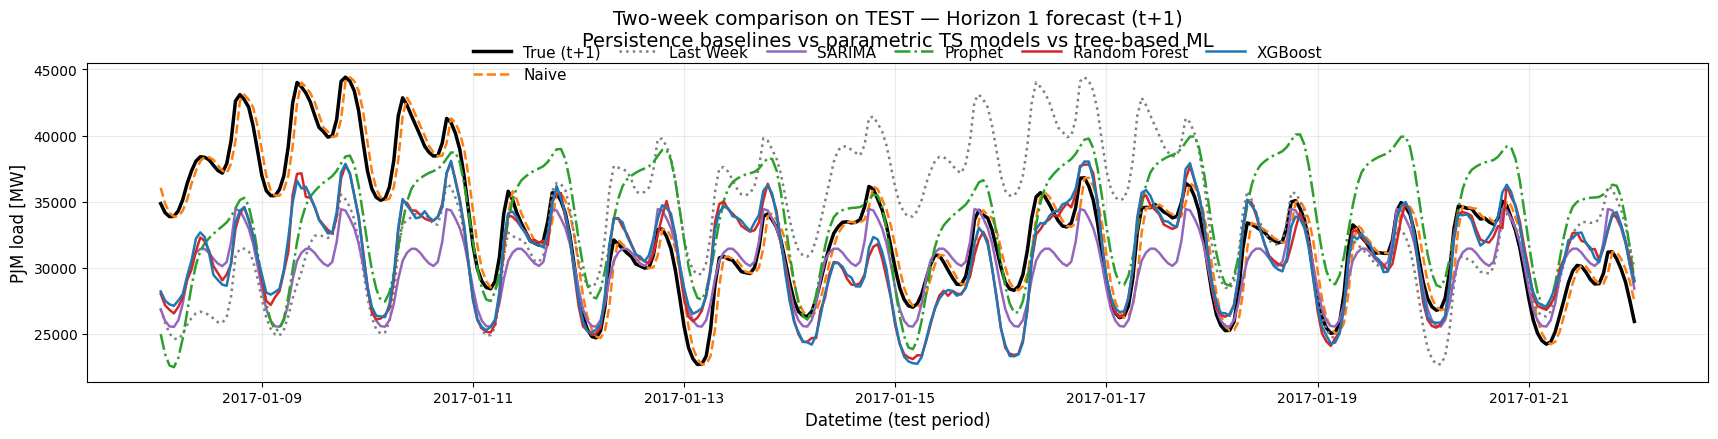

In [37]:
# ---------------------------------------------------------
# 2-week comparison on TEST (horizon 1, including all models)
# Robust to missing predictions in the namespace.
# ---------------------------------------------------------

import matplotlib.pyplot as plt

print("\n=== 2-week horizon-1 comparison on TEST (all models) ===")

week_lag = 168
H = Y_true_test.shape[1]
n_eval_test = Y_true_test.shape[0]

# We need i >= week_lag for the last-week baseline to be defined
max_slice = n_eval_test - week_lag
slice_hours = min(24 * 14, max_slice)   # up to 2 weeks

start_eval = week_lag
end_eval = start_eval + slice_hours

test_index = df_test.index
times = test_index[1 + start_eval : 1 + end_eval]   # timestamps for y_{t+1}

# Ground truth (always available)
y_true_h1 = Y_true_test[start_eval:end_eval, 0]

# ---------------------------------------------------------
# Collect series to plot (only if available)
# ---------------------------------------------------------

series_to_plot = [("True (t+1)", y_true_h1)]

if "Y_pred_naive_test" in globals():
    y_naive_h1 = Y_pred_naive_test[start_eval:end_eval, 0]
    series_to_plot.append(("Naive", y_naive_h1))

if "Y_pred_lastweek_test" in globals():
    # Y_pred_lastweek_test has shape (n_eval_lastweek, H),
    # row r corresponds to eval index = week_lag + r
    lw_start = start_eval - week_lag
    lw_end   = end_eval   - week_lag
    y_lastweek_h1 = Y_pred_lastweek_test[lw_start:lw_end, 0]
    series_to_plot.append(("Last Week", y_lastweek_h1))

if "Y_pred_sarima_test" in globals():
    y_sarima_h1 = Y_pred_sarima_test[start_eval:end_eval, 0]
    series_to_plot.append(("SARIMA", y_sarima_h1))

if "Y_pred_prophet_test" in globals():
    y_prophet_h1 = Y_pred_prophet_test[start_eval:end_eval, 0]
    series_to_plot.append(("Prophet", y_prophet_h1))

if "Y_pred_rf_test" in globals():
    y_rf_h1 = Y_pred_rf_test[start_eval:end_eval, 0]
    series_to_plot.append(("Random Forest", y_rf_h1))

if "Y_pred_xgb_test" in globals():
    y_xgb_h1 = Y_pred_xgb_test[start_eval:end_eval, 0]
    series_to_plot.append(("XGBoost", y_xgb_h1))


# ---------------------------------------------------------
# Plot (compact research-style layout)
# ---------------------------------------------------------

style_map = {
    "True (t+1)":     dict(color="black",       linewidth=2.5, linestyle="-"),
    "Naive":          dict(color="tab:orange",  linewidth=1.8, linestyle="--"),
    "Last Week":      dict(color="tab:gray",    linewidth=1.8, linestyle=":"),
    "SARIMA":         dict(color="tab:purple",  linewidth=1.8, linestyle="-"),
    "Prophet":        dict(color="tab:green",   linewidth=1.8, linestyle="-."),
    "Random Forest":  dict(color="tab:red",     linewidth=1.8, linestyle="-"),
    "XGBoost":        dict(color="tab:blue",    linewidth=1.8, linestyle="-"),
}

plt.figure(figsize=(18, 5))

for label, y in series_to_plot:
    plt.plot(times, y, label=label, **style_map.get(label, {}))

plt.title(
    "Two-week comparison on TEST — Horizon 1 forecast (t+1)\n"
    "Persistence baselines vs parametric TS models vs tree-based ML",
    fontsize=14,
    pad=12,
)

plt.xlabel("Datetime (test period)", fontsize=12)
plt.ylabel("PJM load [MW]", fontsize=12)

n_models = len(series_to_plot)
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    ncol=min(n_models, 6),
    fontsize=11,
    frameon=False,
    columnspacing=1.2,
    handlelength=2.5,
)

plt.grid(True, alpha=0.25)
plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.92])
plt.show()

Anchor index: 368
Anchor time : 2017-01-16 08:00:00
Forecast span: 2017-01-16 09:00:00 → 2017-01-17 08:00:00


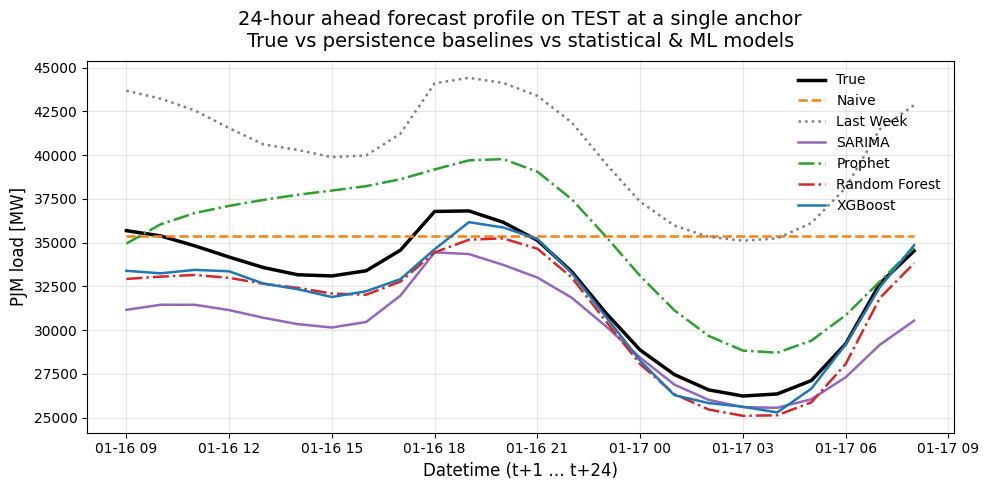

In [38]:
# ---------------------------------------------------------
# 24h multi-step profile at a single anchor (TEST, h=1..24)
# Robust to missing model predictions.
# ---------------------------------------------------------

H = Y_true_test.shape[1]
n_eval_test = Y_true_test.shape[0]
week_lag = 168

# Choose an anchor where last-week is defined and we are well inside the test block
idx = max(week_lag + 200, 0)
idx = min(idx, n_eval_test - 1)

anchor_time = T_eval[idx]                       # time t (anchor)
future_times = df_test.index[idx+1 : idx+1+H]   # t+1 ... t+24

print("Anchor index:", idx)
print("Anchor time :", anchor_time)
print("Forecast span:", future_times[0], "→", future_times[-1])

# ---------------------------------------------------------
# Collect 24-step horizons for each model (if available)
# ---------------------------------------------------------

series_24h = []

# Ground truth
y_true = Y_true_test[idx]
series_24h.append(("True", y_true))

# Naive
if "Y_pred_naive_test" in globals():
    series_24h.append(("Naive", Y_pred_naive_test[idx]))

# Last-week (restricted grid: row r → eval index = week_lag + r)
if "Y_pred_lastweek_test" in globals():
    lw_row = idx - week_lag
    if 0 <= lw_row < Y_pred_lastweek_test.shape[0]:
        series_24h.append(("Last Week", Y_pred_lastweek_test[lw_row]))

# SARIMA
if "Y_pred_sarima_test" in globals():
    series_24h.append(("SARIMA", Y_pred_sarima_test[idx]))

# Prophet
if "Y_pred_prophet_test" in globals():
    series_24h.append(("Prophet", Y_pred_prophet_test[idx]))

# Random Forest
if "Y_pred_rf_test" in globals():
    series_24h.append(("Random Forest", Y_pred_rf_test[idx]))

# XGBoost
if "Y_pred_xgb_test" in globals():
    series_24h.append(("XGBoost", Y_pred_xgb_test[idx]))

# ---------------------------------------------------------
# Plot
# ---------------------------------------------------------

plt.figure(figsize=(10, 5))

style_true = dict(color="black", linewidth=2.5, linestyle="-")
style_map = {
    "Naive":         dict(color="tab:orange", linestyle="--",  linewidth=1.8),
    "Last Week":     dict(color="tab:gray",   linestyle=":",   linewidth=1.8),
    "SARIMA":        dict(color="tab:purple", linestyle="-",   linewidth=1.8),
    "Prophet":       dict(color="tab:green",  linestyle="-.",  linewidth=1.8),
    "Random Forest": dict(color="tab:red",    linestyle="-.",  linewidth=1.8),
    "XGBoost":       dict(color="tab:blue",   linestyle="-",   linewidth=1.8),
}

for label, y in series_24h:
    if label == "True":
        plt.plot(future_times, y, label="True", **style_true)
    else:
        plt.plot(future_times, y, label=label, **style_map.get(label, {}))

plt.title(
    "24-hour ahead forecast profile on TEST at a single anchor\n"
    "True vs persistence baselines vs statistical & ML models",
    fontsize=14,
    pad=10,
)
plt.xlabel("Datetime (t+1 … t+24)", fontsize=12)
plt.ylabel("PJM load [MW]", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


=== Zoom on high-variability demand period (horizon 1) ===


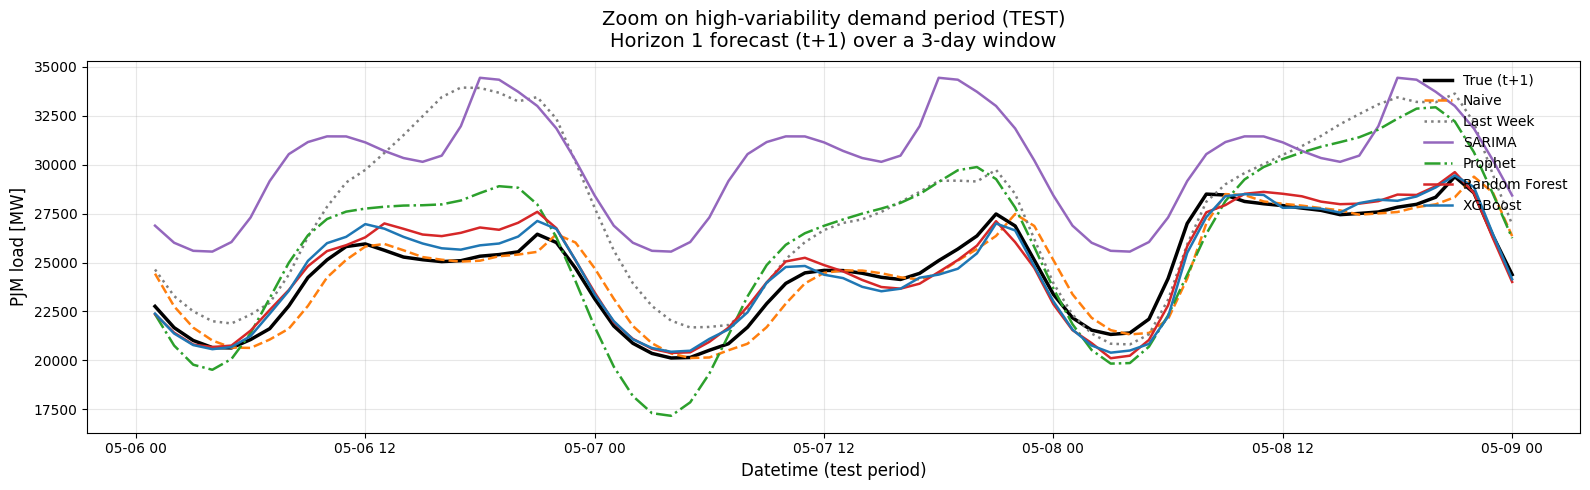

In [39]:
# ---------------------------------------------------------
# Zoom on a 3-day high-variability window — horizon 1 (t+1)
# Robust to missing model predictions.
# ---------------------------------------------------------

print("\n=== Zoom on high-variability demand period (horizon 1) ===")

H = Y_true_test.shape[1]
n_eval_test = Y_true_test.shape[0]
week_lag = 168

# ------------------
# Select a 3-day window in the TEST grid
# ------------------
start_eval = 3000
end_eval = start_eval + 24 * 3    # 3 days

start_eval = max(0, start_eval)
end_eval = min(n_eval_test, end_eval)

test_index = df_test.index
times = test_index[1 + start_eval : 1 + end_eval]   # timestamps for y_{t+1}

y_true_h1 = Y_true_test[start_eval:end_eval, 0]

# ------------------
# Collect series to plot (only if available)
# ------------------
series_to_plot = [("True (t+1)", y_true_h1)]

# Naive persistence
if "Y_pred_naive_test" in globals():
    series_to_plot.append(("Naive", Y_pred_naive_test[start_eval:end_eval, 0]))

# Same-hour-last-week baseline (requires start_eval >= week_lag)
if "Y_pred_lastweek_test" in globals() and start_eval >= week_lag:
    lw_start = start_eval - week_lag
    lw_end   = end_eval   - week_lag
    if 0 <= lw_start < Y_pred_lastweek_test.shape[0]:
        lw_end = min(lw_end, Y_pred_lastweek_test.shape[0])
        series_to_plot.append(("Last Week", Y_pred_lastweek_test[lw_start:lw_end, 0]))

# SARIMA
if "Y_pred_sarima_test" in globals():
    series_to_plot.append(("SARIMA", Y_pred_sarima_test[start_eval:end_eval, 0]))

# Prophet
if "Y_pred_prophet_test" in globals():
    series_to_plot.append(("Prophet", Y_pred_prophet_test[start_eval:end_eval, 0]))

# Random Forest
if "Y_pred_rf_test" in globals():
    series_to_plot.append(("Random Forest", Y_pred_rf_test[start_eval:end_eval, 0]))

# XGBoost
if "Y_pred_xgb_test" in globals():
    series_to_plot.append(("XGBoost", Y_pred_xgb_test[start_eval:end_eval, 0]))


# ------------------
# Plot
# ------------------
style_map = {
    "True (t+1)":     dict(color="black",       linewidth=2.5, linestyle="-"),
    "Naive":          dict(color="tab:orange",  linewidth=1.8, linestyle="--"),
    "Last Week":      dict(color="tab:gray",    linewidth=1.8, linestyle=":"),
    "SARIMA":         dict(color="tab:purple",  linewidth=1.8, linestyle="-"),
    "Prophet":        dict(color="tab:green",   linewidth=1.8, linestyle="-."),
    "Random Forest":  dict(color="tab:red",     linewidth=1.8, linestyle="-"),
    "XGBoost":        dict(color="tab:blue",    linewidth=1.8, linestyle="-"),
}

plt.figure(figsize=(16, 5))

for label, y in series_to_plot:
    plt.plot(times, y, label=label, **style_map.get(label, {}))

plt.title(
    "Zoom on high-variability demand period (TEST)\n"
    "Horizon 1 forecast (t+1) over a 3-day window",
    fontsize=14,
    pad=10,
)
plt.xlabel("Datetime (test period)", fontsize=12)
plt.ylabel("PJM load [MW]", fontsize=12)

plt.legend(loc="upper right", frameon=False)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[Random Forest] Warning: trimming to 13705 rows (y_true=13873, y_pred=13705).
[XGBoost] Warning: trimming to 13705 rows (y_true=13873, y_pred=13705).


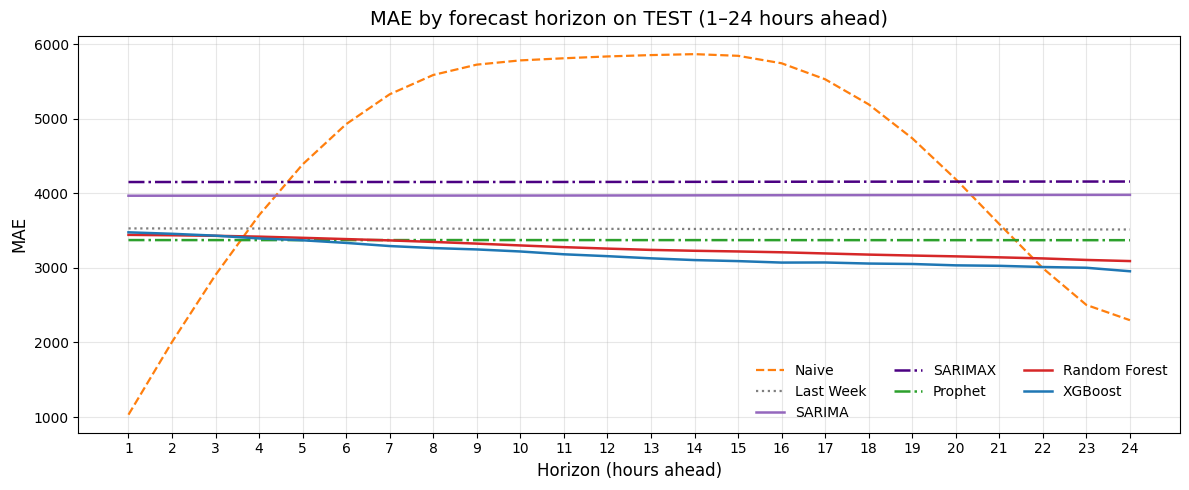

In [40]:
# ---------------------------------------------------------
# MAE by forecast horizon (1–24) — robust to shape mismatches
# ---------------------------------------------------------

def mae_by_horizon_safe(name, y_true, y_pred):
    """
    Compute MAE per horizon, trimming to the common number of rows if needed.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Same number of horizons required
    if y_true.shape[1] != y_pred.shape[1]:
        raise ValueError(
            f"[{name}] Horizon mismatch: y_true has {y_true.shape[1]} cols, "
            f"y_pred has {y_pred.shape[1]} cols."
        )

    # Align number of rows if necessary
    if y_true.shape[0] != y_pred.shape[0]:
        n = min(y_true.shape[0], y_pred.shape[0])
        print(
            f"[{name}] Warning: trimming to {n} rows "
            f"(y_true={y_true.shape[0]}, y_pred={y_pred.shape[0]})."
        )
        y_true = y_true[:n]
        y_pred = y_pred[:n]

    return np.mean(np.abs(y_true - y_pred), axis=0)


horizons = np.arange(1, Y_true_test.shape[1] + 1)

series_mae = []

# === Baselines ===
if "Y_pred_naive_test" in globals():
    series_mae.append(
        ("Naive", mae_by_horizon_safe("Naive", Y_true_test, Y_pred_naive_test))
    )

# Use the restricted grid for last-week (as defined in Section 9)
if "Y_true_test_lastweek" in globals() and "Y_pred_lastweek_test" in globals():
    series_mae.append(
        ("Last Week", mae_by_horizon_safe("Last Week", Y_true_test_lastweek, Y_pred_lastweek_test))
    )

# === SARIMA / SARIMAX / Prophet / RF / XGB ===
if "Y_pred_sarima_test" in globals():
    series_mae.append(
        ("SARIMA", mae_by_horizon_safe("SARIMA", Y_true_test, Y_pred_sarima_test))
    )

if "Y_pred_sarimax_test" in globals():
    series_mae.append(
        ("SARIMAX", mae_by_horizon_safe("SARIMAX", Y_true_test, Y_pred_sarimax_test))
    )

if "Y_pred_prophet_test" in globals():
    series_mae.append(
        ("Prophet", mae_by_horizon_safe("Prophet", Y_true_test, Y_pred_prophet_test))
    )

if "Y_pred_rf_test" in globals():
    series_mae.append(
        ("Random Forest", mae_by_horizon_safe("Random Forest", Y_true_test, Y_pred_rf_test))
    )

if "Y_pred_xgb_test" in globals():
    series_mae.append(
        ("XGBoost", mae_by_horizon_safe("XGBoost", Y_true_test, Y_pred_xgb_test))
    )

plt.figure(figsize=(12, 5))

style_map = {
    "Naive":         dict(color="tab:orange", linestyle="--",  linewidth=1.6),
    "Last Week":     dict(color="tab:gray",   linestyle=":",   linewidth=1.6),
    "SARIMA":        dict(color="tab:purple", linestyle="-",   linewidth=1.8),
    "SARIMAX":       dict(color="indigo",     linestyle="-.",  linewidth=1.8),
    "Prophet":       dict(color="tab:green",  linestyle="-.",  linewidth=1.8),
    "Random Forest": dict(color="tab:red",    linestyle="-",   linewidth=1.8),
    "XGBoost":       dict(color="tab:blue",   linestyle="-",   linewidth=1.8),
}

for label, mae_vals in series_mae:
    plt.plot(horizons, mae_vals, label=label, **style_map.get(label, {}))

plt.title("MAE by forecast horizon on TEST (1–24 hours ahead)", fontsize=14, pad=8)
plt.xlabel("Horizon (hours ahead)", fontsize=12)
plt.ylabel("MAE", fontsize=12)

plt.xticks(horizons)
plt.grid(True, alpha=0.3)
plt.legend(frameon=False, ncol=3)
plt.tight_layout()
plt.show()